In [ ]:
# How many stacked exposures are required for a detection as a function of distance? 
# Simulation for on-board detection

In [1]:
# Imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
import os
from astropy.io import fits
from astropy.table import Table, QTable
from astroduet.background import background_pixel_rate
from astroduet.config import Telescope
from astroduet.utils import duet_abmag_to_fluence, galex_to_duet
from astroduet.image_utils import construct_image, estimate_background, find, run_daophot
from astroduet.diff_image import py_zogy, calculate_diff_image
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image
from astroduet.models import load_bai

# Set up Telescope and values common to all light curves
duet = Telescope()
zodi_weight = {'low': 0.384, 'med': 0.816, 'high': 0.008}
psf_fwhm_pix = duet.psf_fwhm / duet.pixel
psf_array = duet.psf_model(x_size=5,y_size=5).array

frame = np.array([30,30])
exposure = 300 * u.s
oversample = 6
pixel_size_init = duet.pixel / oversample

# Load up the Bai table
bai = QTable(load_bai())
bai['BAI1'], bai['BAI2'] = galex_to_duet([bai['SURFFUV'].value, bai['SURFNUV'].value], duet=duet)

In [67]:
# Read in the EMGW event table. 551 simulations.
datadir = os.path.join(os.getcwd(), '../astroduet/data')

ids, pointings, distances = [], [], []
f = open(datadir+'/emgw_random_draw.dat','r')
for line in f.readlines():
    data = line.split()
    if data[0] != 'sim:nr':
        num_pointings = np.int(data[6])
        if num_pointings <= 9: # Only simulate instances with 9 pointings or less (437 of them)
            ids.append(data[0])
            distances.append(np.float(data[3]))
            pointings.append(num_pointings)
f.close()
print(len(ids))
print(distances[0:50])
print(pointings[0:50])

437
[89.08, 118.01, 66.24, 121.0, 157.66, 134.06, 157.3, 132.56, 142.9, 176.56, 165.32, 126.79, 171.0, 172.01, 103.83, 244.19, 255.66, 207.03, 266.61, 286.85, 83.51, 196.77, 219.07, 270.46, 225.22, 114.17, 107.17, 172.42, 228.53, 159.12, 336.45, 316.85, 235.19, 347.87, 136.29, 320.16, 223.77, 168.47, 327.49, 245.13, 251.26, 313.45, 292.76, 218.09, 251.77, 342.32, 136.07, 85.47, 331.27, 494.18]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [72]:
# Take input: sim ids, number of pointings, distance
emgw = QTable([ids, pointings, distances * u.Mpc], names=('id', 'pointings', 'distance'))

# Store galaxy/other sim details for future reference
sim_details = QTable(names=('id', 'mag', 'rad', 'n', 'theta', 'ellip', 'pos', 'start_time', 'phase', 'zodi'), 
                     dtype=('i2', 'f4', 'f4', 'i1', 'f4', 'f4', 'f4', 'i4', 'f4', 'S4'))

# Generate simulation data (this takes a while!!)
for i, e in enumerate(emgw):
    
    # Generate a background galaxy from Bai catalogue
    # Pick within a distance range
    try:
        galaxy = np.random.choice(bai[(bai['DIST'] > (e['distance']-20*u.Mpc)) & (bai['DIST'] < (e['distance']+20*u.Mpc))])
    except:
        # Distance range ain't working - just pick any random galaxy over 50 Mpc
        galaxy = np.random.choice(bai[bai['DIST'] > 50*u.Mpc])
    
    # Correct radius for distance
    rad = galaxy['RAD'] * u.arcsec * galaxy['DIST'] * u.Mpc / e['distance']
    rad_pix = rad / pixel_size_init
    
    # Base n on Hubble type
    if galaxy['MORPH'] >= 0: n = 1 
    else: n = 4

    # Randomise theta, ellip, position as fraction of r_eff
    theta = np.random.uniform(low=0,high=np.pi)
    ellip = np.random.uniform(low=0.1,high=1)
    pos = np.random.uniform(low=0.1,high=3) 
    
    # Calculate x_0 and y_0
    d = pos * rad / pixel_size_init
    x_0 = d * np.cos(theta) 
    y_0 = d * np.sin(theta)
    
    # Set up galaxy parameters
    gal_params1 = {'magnitude': galaxy['BAI1'], 'r_eff': rad_pix.value, 'n': n, 'theta': theta, \
                   'ellip': ellip, 'x_0': x_0.value, 'y_0': y_0.value}
    #gal_params2 = {'magnitude': galaxy['BAI2'], 'r_eff': rad_pix.value, 'n': n, 'theta': theta, \
    #               'ellip': ellip, 'x_0': x_0.value, 'y_0': y_0.value}
    
    # Next, generate the light curve for the shock and blue kilonova models
    # Assume we start tiling 40 mins after the event, at a random orbit phase
    start_time = 2400. * u.s + np.random.choice(np.arange(e['pointings'])+1) * exposure
    end_time = 24000. * u.s # Only generate a quarter day + 2400s data for now
    phase_start = np.random.random()
    
    # Randomise the zodi setting
    z = np.random.random()
    if z <= zodi_weight['low']: zodi = 'low'
    elif (z > zodi_weight['low']) & (z <= (zodi_weight['low']+zodi_weight['med'])): zodi = 'mid'
    else: zodi = 'high'
    
    sim_details.add_row((e['id'],galaxy['BAI1'],rad,n,theta,ellip,pos,start_time,phase_start,zodi))
    
    # Get lightcurve first then sort out the pointings (inefficient but best we can do with infrastructure)
    observing_windows = np.array([[start_time.to(u.s).value,end_time.to(u.s).value]]) * u.s
    file = "emgw{}_40min".format(i)
    
    # Get lightcurve through images with debug on so it's storing files
    lightcurve_shock = get_lightcurve("shock_5e10.dat", distance=e['distance'], exposure=exposure, duet=duet,
                                        observing_windows=observing_windows, phase_start=phase_start)
    im_lightcurve_shock = lightcurve_through_image(lightcurve_shock, exposure=exposure, frame=frame, duet=duet,
                                                   gal_type='custom', gal_params=gal_params1,
                                                   debug=True, debugfilename=file+'_shock',zodi=zodi)
            
    lightcurve_blukn = get_lightcurve("kilonova_0.04.dat", distance=e['distance'], exposure=exposure, duet=duet,
                                      observing_windows=observing_windows, phase_start=phase_start)
    im_lightcurve_blukn = lightcurve_through_image(lightcurve_blukn, exposure=exposure, frame=frame, duet=duet,
                                                   gal_type='custom', gal_params=gal_params1,
                                                   debug=True, debugfilename=file+'_blukn',zodi=zodi)
            
    print("Done: "+file)

INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw0_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw1_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw2_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw3_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw4_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw5_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw6_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw7_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw8_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw9_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw10_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw11_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw12_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw13_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw14_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw15_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw16_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw17_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw18_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw19_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw20_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw21_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw22_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw23_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw24_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw25_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw26_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw27_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw28_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw29_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw30_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw31_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw32_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw33_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw34_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw35_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw36_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw37_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw38_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw39_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw40_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw41_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw42_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw43_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw44_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw45_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw46_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw47_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw48_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw49_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw50_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw51_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw52_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw53_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw54_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw55_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw56_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw57_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw58_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw59_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw60_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw61_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw62_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw63_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw64_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw65_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw66_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw67_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw68_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw69_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw70_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw71_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw72_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw73_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw74_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw75_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw76_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw77_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw78_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw79_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw80_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw81_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw82_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw83_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw84_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw85_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw86_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw87_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw88_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw89_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw90_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw91_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw92_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw93_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw94_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw95_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw96_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw97_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw98_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw99_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw100_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw101_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw102_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw103_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw104_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw105_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw106_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw107_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw108_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw109_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw110_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw111_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw112_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw113_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw114_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw115_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw116_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw117_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw118_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw119_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw120_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw121_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw122_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw123_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw124_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw125_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw126_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw127_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw128_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw129_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw130_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw131_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw132_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw133_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw134_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw135_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw136_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw137_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw138_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw139_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw140_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw141_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Done: emgw142_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw143_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw144_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw145_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw146_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw147_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw148_40min
INFO: Creating images [astroduet.lightcurve]


/Users/hannah/Dropbox/PhD/DUET/duet-astro/astroduet/lightcurve.py:728: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  log.warn("No good detections in this field")


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


/Users/hannah/Dropbox/PhD/DUET/duet-astro/astroduet/lightcurve.py:728: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  log.warn("No good detections in this field")


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
Done: emgw149_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw150_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw151_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw152_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw153_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw154_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Done: emgw155_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw156_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw157_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw158_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw159_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw160_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw161_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw162_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw163_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw164_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw165_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw166_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw167_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw168_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw169_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw170_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw171_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw172_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw173_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw174_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw175_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw176_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw177_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().

Done: emgw178_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw179_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw180_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw181_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw182_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw183_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw184_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw185_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw186_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw187_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw188_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw189_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw190_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw191_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw192_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw193_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw194_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw195_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw196_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw197_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw198_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw199_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw200_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw201_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw202_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw203_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw204_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw205_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw206_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw207_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw208_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw209_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw210_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw211_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw212_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw213_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw214_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw215_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw216_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Done: emgw217_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw218_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw219_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw220_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Done: emgw221_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw222_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw223_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw224_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw225_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw226_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw227_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw228_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw229_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw230_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw231_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw232_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw233_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw234_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw235_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw236_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw237_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw238_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw239_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw240_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw241_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw242_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw243_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw244_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw245_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw246_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw247_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw248_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw249_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw250_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw251_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw252_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw253_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw254_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw255_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw256_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Done: emgw257_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw258_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw259_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw260_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw261_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw262_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw263_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw264_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw265_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw266_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw267_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw268_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw269_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw270_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw271_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw272_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw273_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw274_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw275_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw276_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw277_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw278_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw279_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw280_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw281_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw282_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw283_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw284_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw285_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw286_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw287_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw288_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw289_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw290_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw291_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw292_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw293_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw294_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw295_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw296_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw297_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw298_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw299_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw300_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw301_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw302_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw303_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw304_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Done: emgw305_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw306_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw307_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw308_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw309_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw310_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Done: emgw311_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw312_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw313_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw314_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw315_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw316_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw317_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw318_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw319_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw320_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw321_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw322_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw323_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw324_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw325_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw326_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw327_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw328_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw329_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw330_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw331_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw332_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw333_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw334_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw335_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw336_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw337_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw338_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw339_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw340_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw341_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw342_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw343_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw344_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw345_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw346_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw347_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw348_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw349_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw350_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw351_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw352_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw353_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw354_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw355_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw356_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw357_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw358_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Done: emgw359_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw360_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw361_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw362_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw363_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw364_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw365_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw366_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw367_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw368_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw369_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw370_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw371_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw372_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw373_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw374_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw375_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw376_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw377_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw378_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw379_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw380_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw381_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw382_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw383_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw384_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw385_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw386_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw387_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw388_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw389_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw390_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw391_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done: emgw392_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw393_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw394_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw395_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw396_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw397_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw398_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw399_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw400_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw401_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw402_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw403_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw404_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw405_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw406_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw407_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw408_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw409_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw410_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw411_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw412_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw413_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw414_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw415_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw416_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw417_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw418_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw419_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw420_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw421_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw422_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw423_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw424_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw425_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw426_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw427_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw428_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw429_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw430_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw431_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw432_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw433_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw434_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw435_40min
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
INFO: Creating images [astroduet.lightcurve]


INFO: Constructing reference images [astroduet.lightcurve]
INFO: Finding source in integrated diff image [astroduet.lightcurve]
INFO: Measuring fluxes and creating light curve [astroduet.lightcurve]
Done: emgw436_40min


Now running shock
76 89.08 Mpc shock 2
DUET1 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


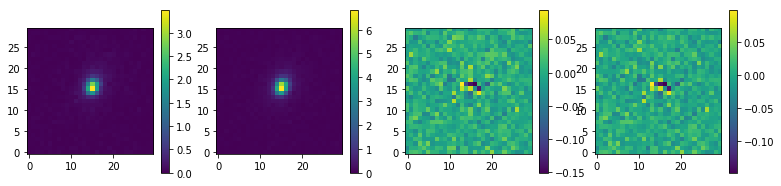

DUET2 (inverse)
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
16.954149728171206 15.179355597173782 17.836685099077158                 0.0
 16.98264456272189 15.169633689534422 -17.62165031298728 0.18729783874568715


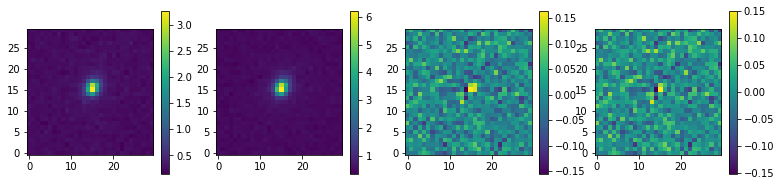

Now running blukn
Now running shock
579 118.01 Mpc shock 7
DUET1 (inverse)
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.496813720306049 14.695889129991906 0.4730215758172533 0.07707403436191197


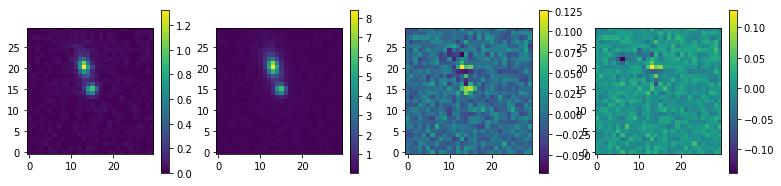

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


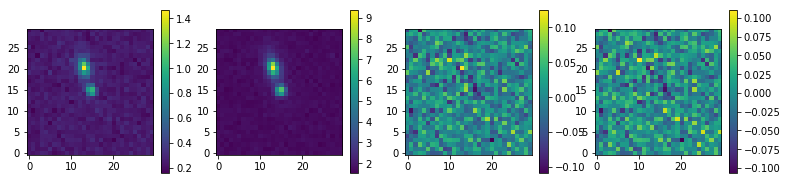

Now running blukn
579 118.01 Mpc blukn 14
DUET1 (inverse)
      x_fit              y_fit            flux_fit            flux_unc     
                                           ph / s              ph / s      
------------------ ----------------- ------------------ -------------------
14.762253391071493 14.74283558726105 2.3170733900428937 0.04391736540322822


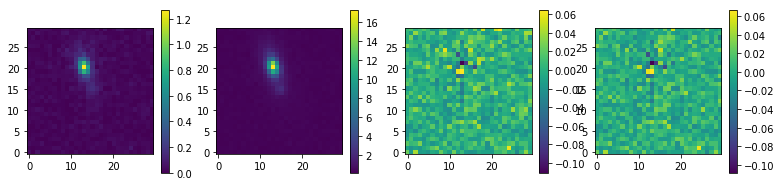

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


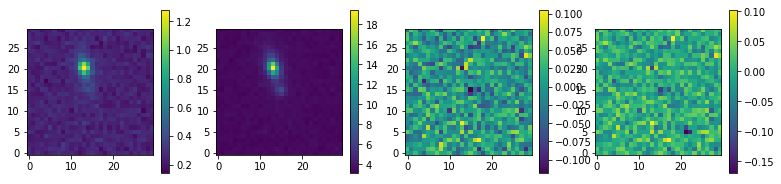

Now running shock
68 66.24 Mpc shock 13
DUET1 (inverse)
      x_fit              y_fit             flux_fit           flux_unc     
                                            ph / s             ph / s      
------------------ ------------------ ------------------ ------------------
14.519840755195581 14.726859152586346 1.9026146436998699 0.1376047780153001


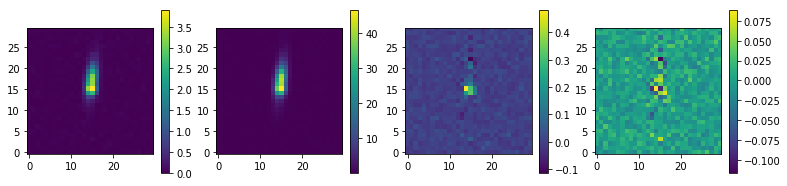

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


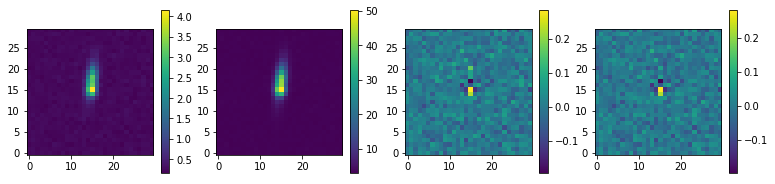

Now running blukn
68 66.24 Mpc blukn 15 DUET2
DUET1
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


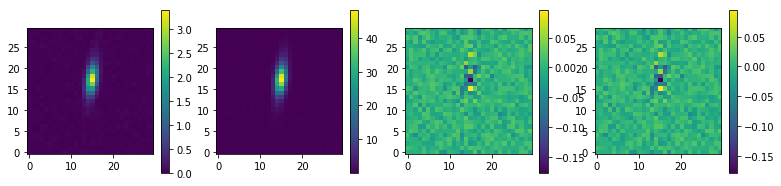

DUET2
      x_fit              y_fit            flux_fit            flux_unc     
                                           ph / s              ph / s      
------------------ ----------------- ------------------ -------------------
14.517667440791028 14.60584746204504 0.6145266245184197 0.10703776772345582


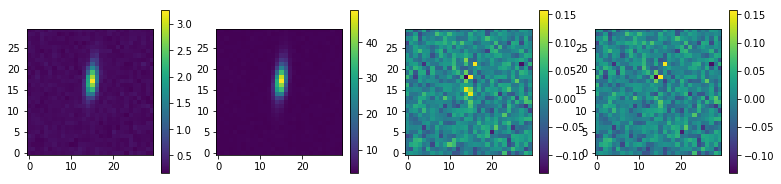

Now running shock
emgw3_40min_shock shock 121.0 Mpc False Positive (band 1), inverse
31 121.0 Mpc shock 1
DUET1 (inverse)
      x_fit              y_fit              flux_fit            flux_unc     
                                             ph / s              ph / s      
------------------ ------------------ ------------------- -------------------
13.278579828202087 14.922918074785407 0.28442624475901523 0.04764645259877095


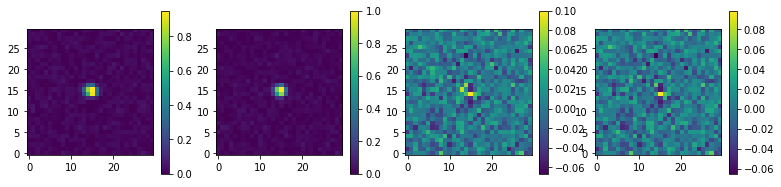

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


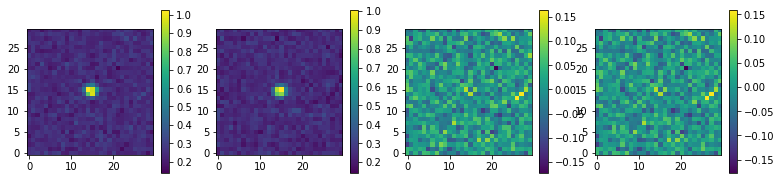

31 121.0 Mpc shock 12
DUET1 (inverse)
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
15.127329767137203 14.194774259489412 0.5846645721314639 0.09936055141850927


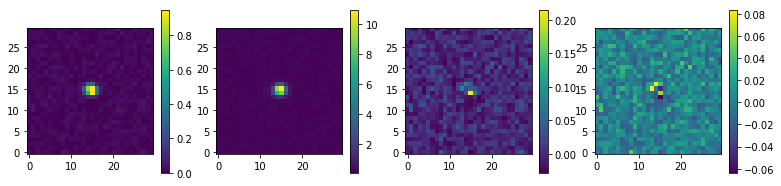

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


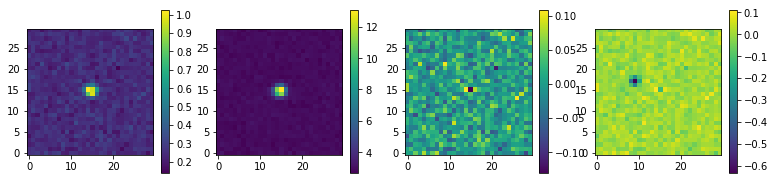

Now running blukn
Now running shock
412 157.66 Mpc shock 20
DUET1 (inverse)
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.897838397540047 15.113656371949576 0.5516227073397083 0.10629860831839338


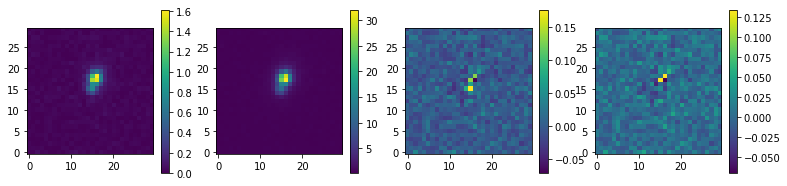

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


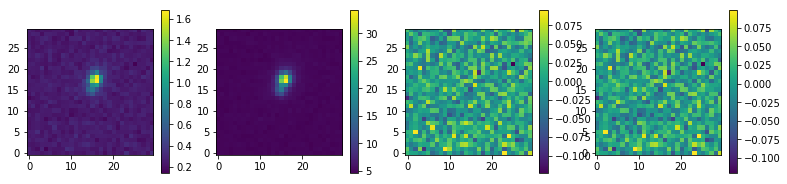

Now running blukn
412 157.66 Mpc blukn 15 DUET2
DUET1
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


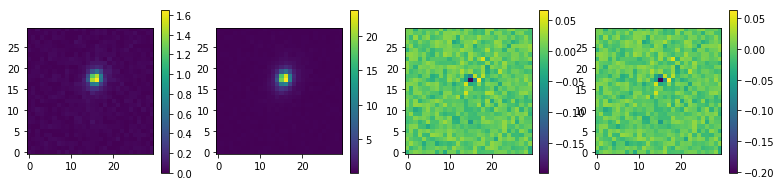

DUET2
      x_fit              y_fit              flux_fit             flux_unc       
                                             ph / s               ph / s        
------------------ ------------------ ------------------- ----------------------
14.676729616648595 16.071994449739684 0.21381591283847112 -0.0074896540014996495


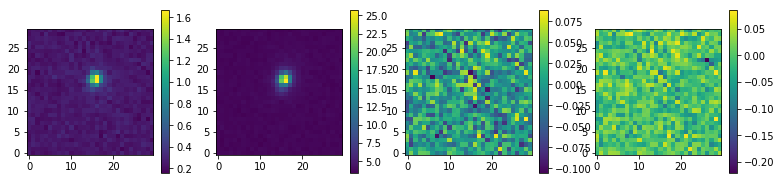

Now running shock
emgw5_40min_shock shock 134.06 Mpc False Positive (band 1), inverse
434 134.06 Mpc shock 4
DUET1 (inverse)
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ----------------- ------------------- -------------------
15.235648366932075 14.71834321396601 0.48063828345002635 0.09192411068993124


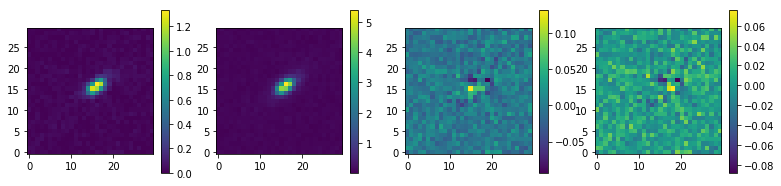

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


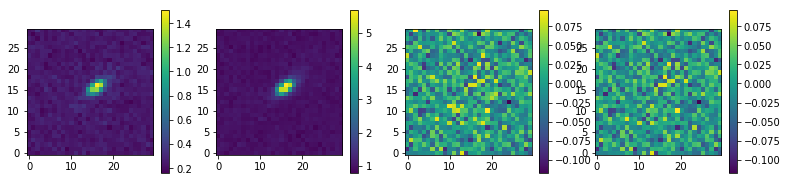

emgw5_40min_shock shock 134.06 Mpc False Positive (band 1), inverse
434 134.06 Mpc shock 5
DUET1 (inverse)
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ----------------- ------------------- -------------------
15.263425964992503 14.65194009406073 0.47088061946153403 0.08357458483153718


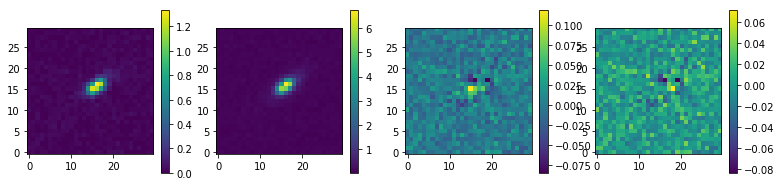

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


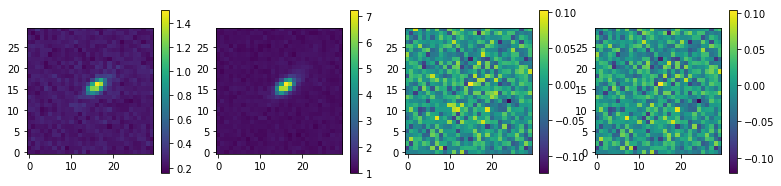

emgw5_40min_shock shock 134.06 Mpc False Positive (band 1), inverse
434 134.06 Mpc shock 6
DUET1 (inverse)
      x_fit              y_fit            flux_fit           flux_unc     
                                           ph / s             ph / s      
------------------ ----------------- ----------------- -------------------
15.243321288031835 14.66550608310295 0.483455111285121 0.07702674700433476


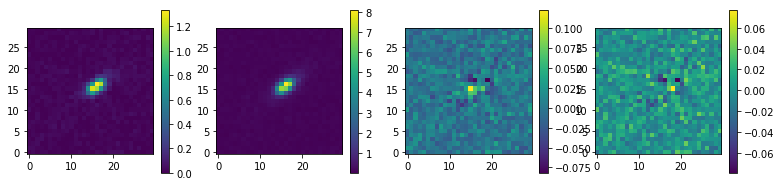

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


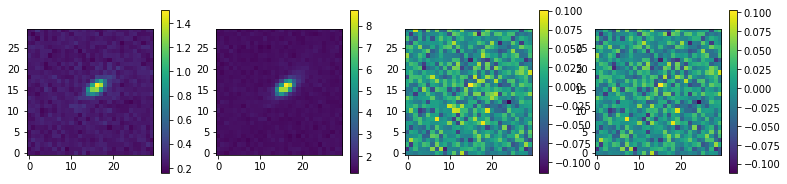

emgw5_40min_shock shock 134.06 Mpc False Positive (band 1), inverse
434 134.06 Mpc shock 7
DUET1 (inverse)
      x_fit             y_fit             flux_fit            flux_unc     
                                           ph / s              ph / s      
----------------- ------------------ ------------------ -------------------
15.15508575622122 14.639384594209952 0.5306300408949617 0.08063543029913353


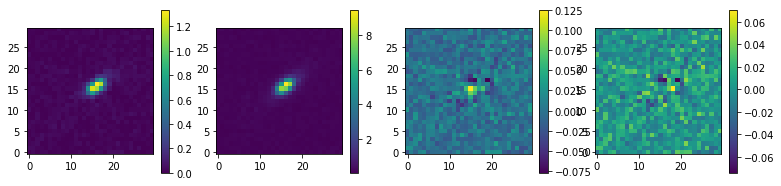

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


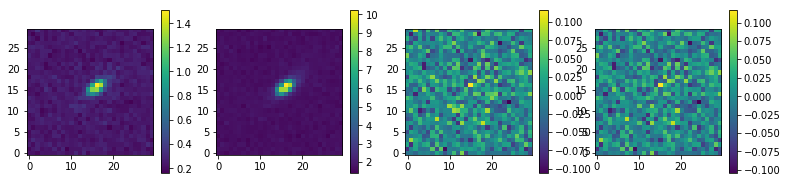

emgw5_40min_shock shock 134.06 Mpc False Positive (band 1), inverse
434 134.06 Mpc shock 8
DUET1 (inverse)
      x_fit              y_fit            flux_fit            flux_unc     
                                           ph / s              ph / s      
------------------ ----------------- ------------------ -------------------
15.160518715958535 14.67440003165048 0.6059258285228136 0.08088152613409706


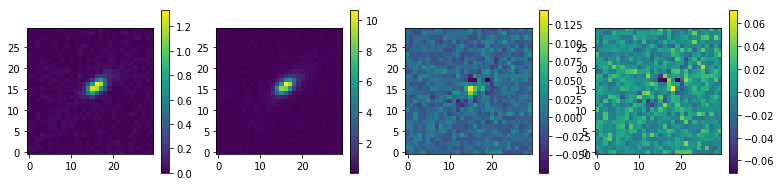

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


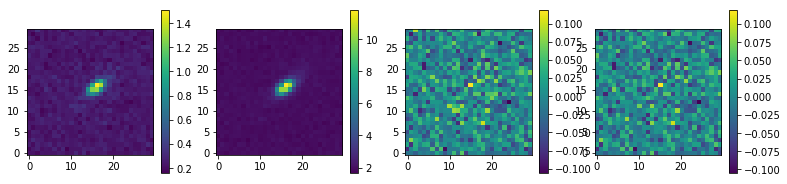

emgw5_40min_shock shock 134.06 Mpc False Positive (band 1), inverse
434 134.06 Mpc shock 9
DUET1 (inverse)
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
15.108346500445332 14.670238987221987 0.6397313566907669 0.08418628849346271


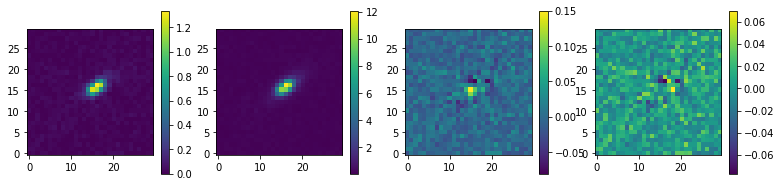

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


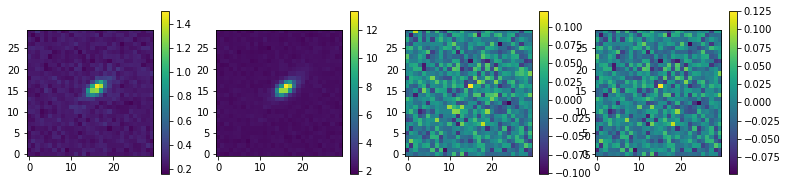

emgw5_40min_shock shock 134.06 Mpc False Positive (band 1), inverse
434 134.06 Mpc shock 10
DUET1 (inverse)
      x_fit              y_fit            flux_fit            flux_unc     
                                           ph / s              ph / s      
------------------ ----------------- ------------------ -------------------
15.070009395654287 14.66483000334129 0.6874342773763495 0.08375907417214469


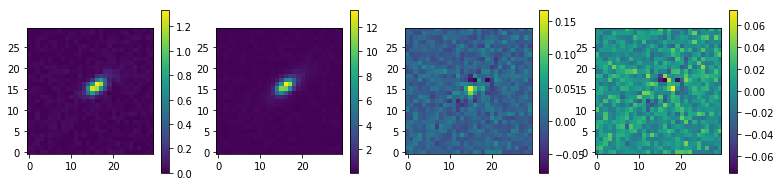

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


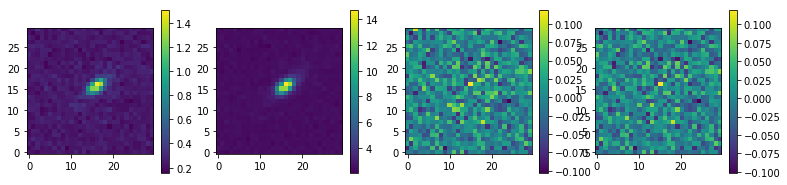

434 134.06 Mpc shock 11
DUET1 (inverse)
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
15.007025834601574 14.626585369756585 0.7099642037731289 0.08115811310041589


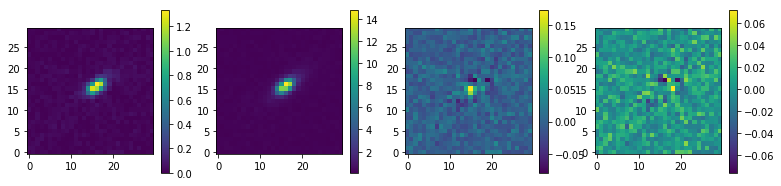

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


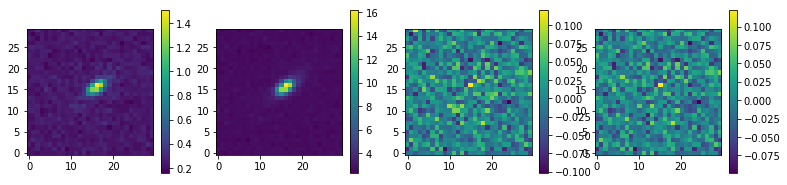

Now running blukn
Now running shock
emgw6_40min_shock shock 157.3 Mpc False Positive (band 2)
422 157.3 Mpc shock 15 DUET2
DUET1
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


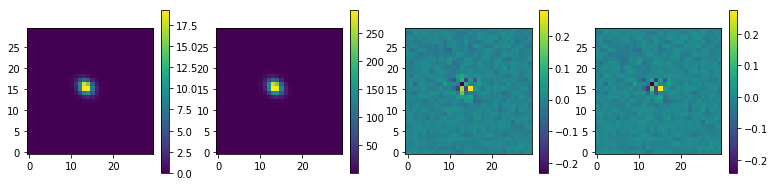

DUET2
      x_fit              y_fit            flux_fit            flux_unc     
                                           ph / s              ph / s      
------------------ ----------------- ------------------ -------------------
13.684963971794799 14.15624629738044 0.8408862783718143  0.1169024243528661
12.216507587202354 16.13452203331226 0.8462841652095591 0.15612038738622824


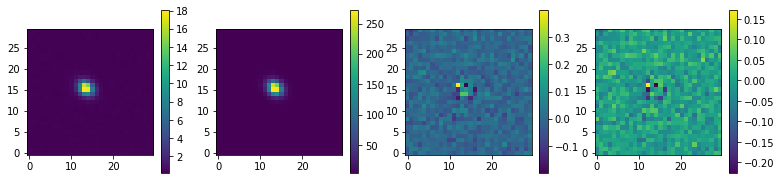

422 157.3 Mpc shock 26
DUET1 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


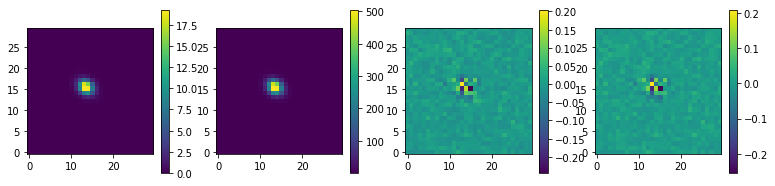

DUET2 (inverse)
      x_fit             y_fit             flux_fit            flux_unc      
                                           ph / s              ph / s       
----------------- ------------------ ------------------ --------------------
15.98643928428559 14.884307781388879 0.3599175470157623 -0.05078023391998465


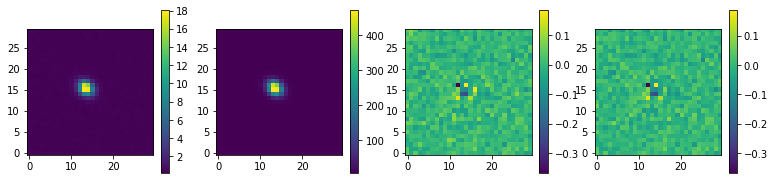

Now running blukn


Photometry failed!
Now running shock
17 132.56 Mpc shock 10
DUET1 (inverse)
      x_fit             y_fit             flux_fit            flux_unc     
                                           ph / s              ph / s      
----------------- ------------------ ------------------ -------------------
14.54038645795078 14.576009999400268 0.4375498920333706 0.07682563683978869


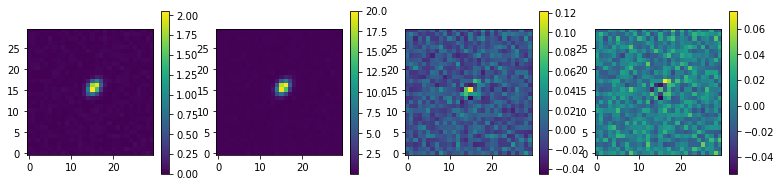

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


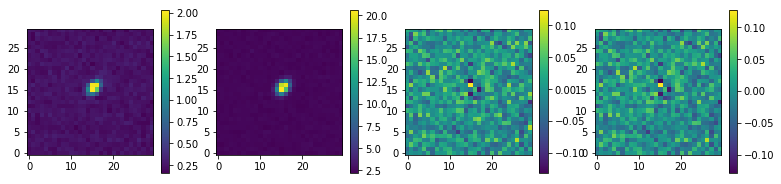

Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
emgw8_40min_blukn blukn 142.9 Mpc False Positive (band 2)
217 142.9 Mpc blukn 1 DUET2
DUET1
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


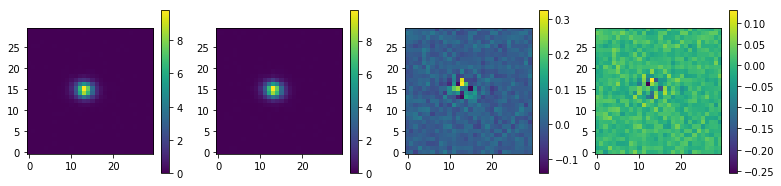

DUET2
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ------------------ ------------------ -------------------
14.630145697482977 14.819890991751935 -2.831835228664271 0.28304089284590783


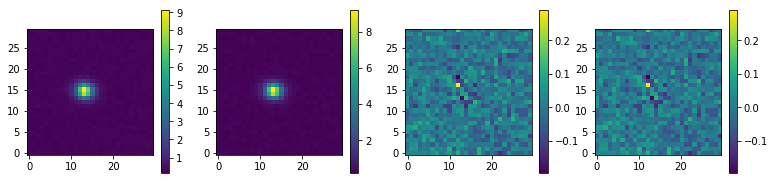

Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


284 176.56 Mpc shock 16
DUET1 (inverse)
      x_fit              y_fit              flux_fit            flux_unc     
                                             ph / s              ph / s      
------------------ ------------------ ------------------- -------------------
14.763560743381404  14.74918404279849   0.473877946949914 0.09338741616829602
28.624509884075156 20.178688605378717 0.13402766980184141  0.0253330516524902
16.748849868858382 27.682915206042477 0.18678197451911116 0.03538875420405008


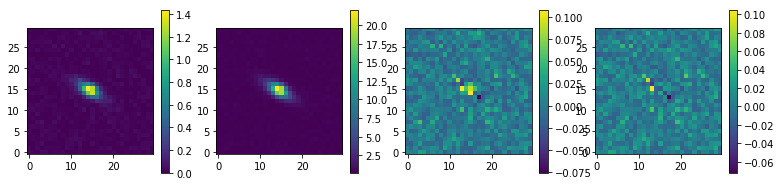

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


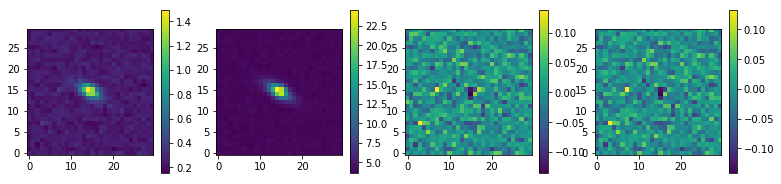

Now running blukn
emgw9_40min_blukn blukn 176.56 Mpc False Positive (band 2)
284 176.56 Mpc blukn 2 DUET2
DUET1
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


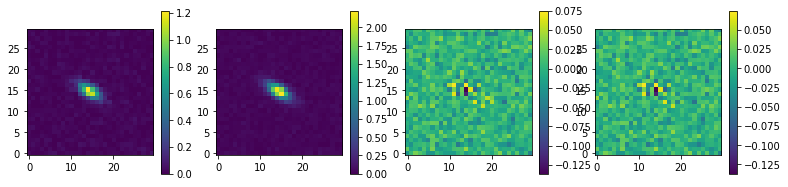

DUET2
      x_fit             y_fit            flux_fit            flux_unc     
                                          ph / s              ph / s      
----------------- ----------------- ------------------ -------------------
16.70812517447702 15.21697445011911 0.5323313959894215 0.10022258700436089


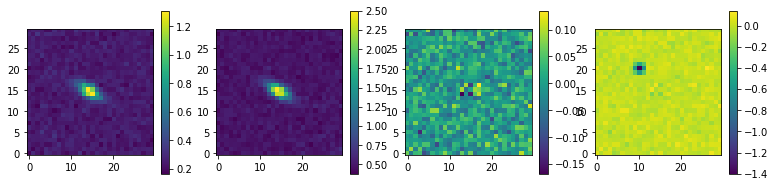

Now running shock
272 165.32 Mpc shock 15
DUET1 (inverse)
      x_fit             y_fit              flux_fit            flux_unc     
                                            ph / s              ph / s      
----------------- ------------------ ------------------- -------------------
14.68868090430753 14.816577418165506 0.28496946033530796 0.05272522785922185


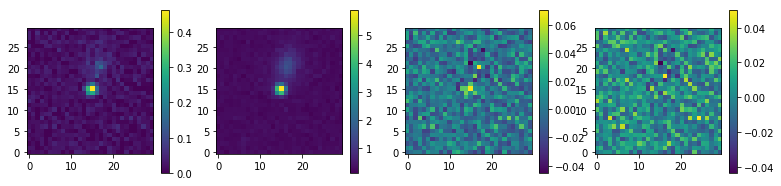

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


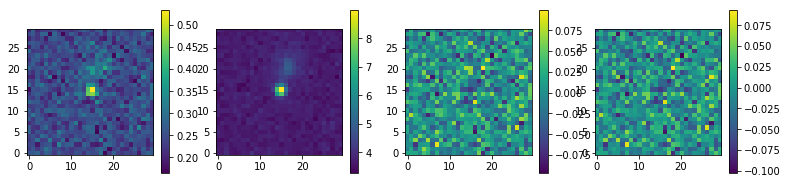

Now running blukn
Now running shock
emgw11_40min_shock shock 126.79 Mpc False Positive (band 1), inverse
175 126.79 Mpc shock 7
DUET1 (inverse)
      x_fit              y_fit              flux_fit            flux_unc     
                                             ph / s              ph / s      
------------------ ------------------ ------------------- -------------------
15.376306675482052 15.129380255785032 0.41043331353401896 0.07855166632519606


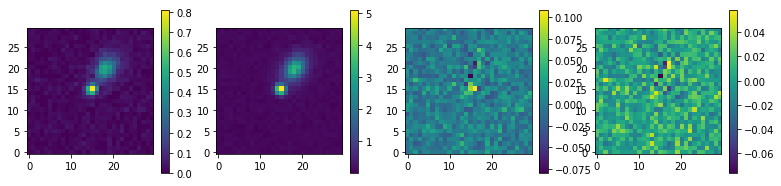

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


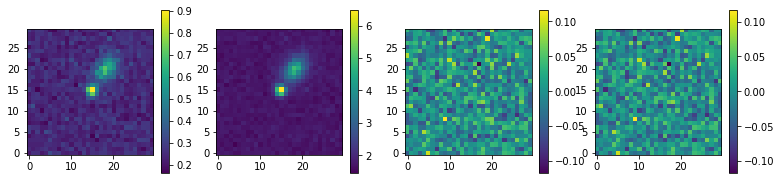

175 126.79 Mpc shock 8
DUET1 (inverse)
      x_fit             y_fit            flux_fit            flux_unc     
                                          ph / s              ph / s      
------------------ ---------------- ------------------ -------------------
15.316367146813533 15.0778351960276 0.4662317872058605 0.07616409703171409


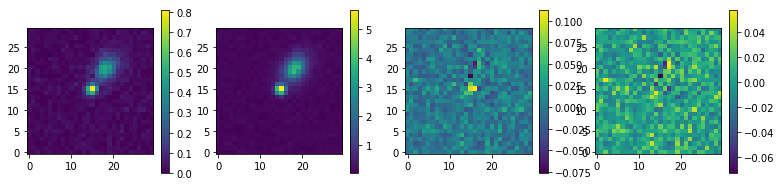

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


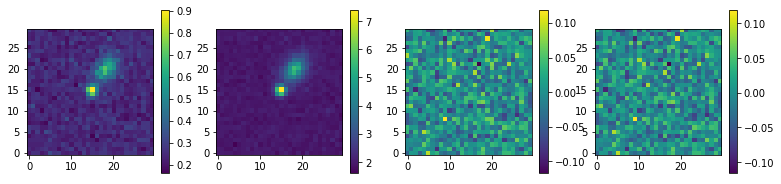

Now running blukn
Now running shock
332 171.0 Mpc shock 14
DUET1 (inverse)
      x_fit             y_fit             flux_fit            flux_unc     
                                           ph / s              ph / s      
----------------- ------------------ ------------------ -------------------
14.64632387248405 15.243919810842554 0.3366036280958736 0.06722923658717055


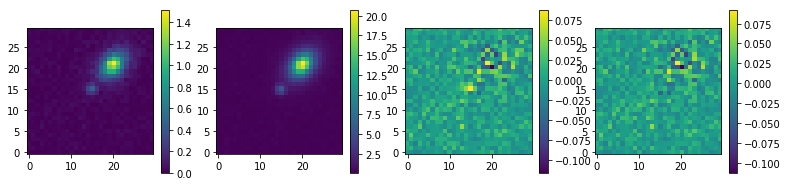

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


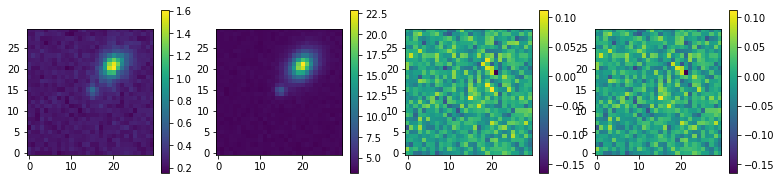

Now running blukn
Now running shock
348 172.01 Mpc shock 24
DUET1 (inverse)
      x_fit              y_fit              flux_fit            flux_unc     
                                             ph / s              ph / s      
------------------ ------------------ ------------------- -------------------
14.742032908985314 14.578505080994839 0.47312249944336543 0.09161111554263403


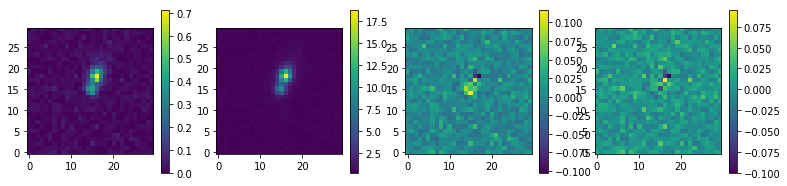

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


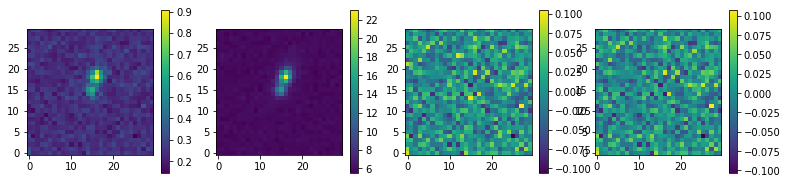

Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


18 103.83 Mpc shock 13
DUET1 (inverse)
      x_fit              y_fit             flux_fit            flux_unc     
                                            ph / s              ph / s      
------------------ ----------------- ------------------- -------------------
 1.776923484896281 8.520050543692586 0.20994700986910256  0.0340183197585941
 14.69626022627858 15.63232621515348  0.7645534384337743 0.13893664201423778
27.200316661534064 22.72827757621274 0.18966247877784737 0.02967434183897144


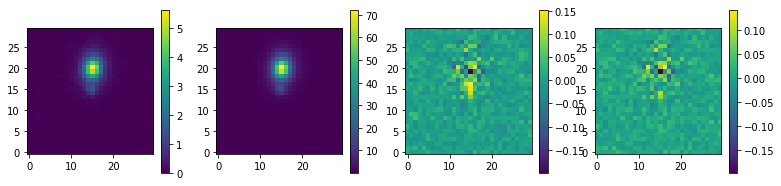

DUET2 (inverse)
x_fit y_fit flux_fit flux_unc
             ph / s   ph / s 
----- ----- -------- --------


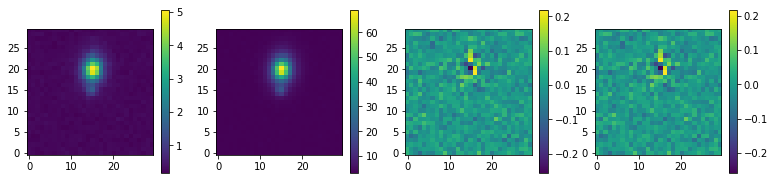

Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inverse
emgw17_40min_shock shock 207.03 Mpc False Positive (band 1), inv

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
emgw23_40min_blukn blukn 270.46 Mpc False Positive (band 1)
emgw23_40min_blukn blukn 270.46 Mpc False Positive (band 1)
Now running shock
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), inverse
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), inverse
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), inverse
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), inverse
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), inverse
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), inverse
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), inverse
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), inverse
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), inverse
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), inverse
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), inverse
emgw24_40min_shock shock 225.22 Mpc False Positive (band 1), invers

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw29_40min_blukn blukn 159.12 Mpc False Positive (band 2)
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
emgw33_40min_shock shock 347.87 Mpc False Positive (band 1), inverse
emgw33_40min_shock shock 347.87 Mpc False Positive (band 1), inverse
emgw33_40min_shock shock 347.87 Mpc False Positive (band 1), inverse
emgw33_40min_shock shock 347.87 Mpc False Positive (band 1), inverse
emgw33_40min_shock shock 347.87 Mpc False Positive (band 1), inverse
emgw33_40min_shock shock 347.87 Mpc False Positive (band 1), inverse
emgw33_40min_shock shock 347.87 Mpc False Positive (band 1), inverse
emgw33_40min_shock shock 347.87 Mpc False Positive (band 1), inverse
emgw33_40min_shock shock 347.87 Mpc False Positive (band 1), inverse
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
emgw38_40min_shock shock 327.49 Mpc False Positive (band 1), inverse
emgw38_40min_shock shock 327.49 Mpc False Positive (band 1), inverse
emgw38_40min_shock shock 327.49 Mpc False Positive (band 1), inverse
emgw38_40min_shock shock 327.49 Mpc False Positive (band 1), inverse
emgw38_40min_shock shock 327.49 Mpc False Positive (band 1), inverse
emgw38_40min_shock shock 327.49 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), inverse
emgw44_40min_shock shock 251.77 Mpc False Positive (band 1), invers

Photometry failed!
Now running shock
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)


Photometry failed!


emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
Photometry failed!
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)


Photometry failed!
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Photometry failed!
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)


Photometry failed!
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)


Photometry failed!
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)


Photometry failed!
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)


Photometry failed!
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)


Photometry failed!
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)


Photometry failed!
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)


Photometry failed!
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
emgw47_40min_shock shock 85.47 Mpc False Positive (band 2)
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inverse
emgw61_40min_shock shock 417.77 Mpc False Positive (band 1), inv

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw68_40min_shock shock 112.21 Mpc False Positive (band 1), inverse
emgw68_40min_shock shock 112.21 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Now running shock
emgw75_40min_shock shock 192.92 Mpc False Positive (band 2), inverse
emgw75_40min_shock shock 192.92 Mpc False Positive (band 2), inverse
emgw75_40min_shock shock 192.92 Mpc False Positive (band 2), inverse
emgw75_40min_shock shock 192.92 Mpc False Positive (band 2), inverse
Now running blukn
Now running shock
emgw76_40min_shock shock 193.54 Mpc False Positive (band 1), inverse
emgw76_40min_shock shock 193.54 Mpc False Positive (band 1), inverse
emgw76_40min_shock shock 193.54 Mpc False Positive (band 1), inverse
emgw76_40min_shock shock 193.54 Mpc False Positive (band 1), inverse
emgw76_40min_shock shock 193.54 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


Photometry failed!


Photometry failed!


Photometry failed!
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


Photometry failed!


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Photometry failed!
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!
Now running shock
Now running blukn
emgw102_40min_blukn blukn 157.01 Mpc False Positive (band 1)
emgw102_40min_blukn blukn 157.01 Mpc False Positive (band 1)
emgw102_40min_blukn blukn 157.01 Mpc False Positive (band 1)
emgw102_40min_blukn blukn 157.01 Mpc False Positive (band 1)
emgw102_40min_blukn blukn 157.01 Mpc False Positive (band 1)
emgw102_40min_blukn blukn 157.01 Mpc False Positive (band 1)
emgw102_40min_blukn blukn 157.01 Mpc False Positive (band 1)
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
emgw104_40min_shock shock 51.87 Mpc False Positive (band 1), inverse
emgw104_40min_shock shock 51.87 Mpc False Positive (band 1), inverse
emgw104_40min_shock shock 51.87 Mpc False Positive (band 2), inverse
emgw104_40min_shock shock 51.87 Mpc False Positive (band 2), inverse
emgw104_40min_shock shock 51.87 Mpc False Positive (band 2), inverse
emgw104_40min_shock shock 51.87 Mpc False Positive (band 2), inverse
emgw104_40min_shock shock 51.87 Mpc False Positive (band 2), inverse
Now running blukn
Now running shock
Now running blukn
emgw105_40min_blukn blukn 393.5 Mpc False Positive (band 1)
Now running shock
emgw106_40min_shock shock 154.5 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn


Photometry failed!
Now running shock
emgw109_40min_shock shock 438.23 Mpc False Positive (band 1), inverse
emgw109_40min_shock shock 438.23 Mpc False Positive (band 1), inverse
emgw109_40min_shock shock 438.23 Mpc False Positive (band 1), inverse
emgw109_40min_shock shock 438.23 Mpc False Positive (band 1), inverse
emgw109_40min_shock shock 438.23 Mpc False Positive (band 1), inverse
emgw109_40min_shock shock 438.23 Mpc False Positive (band 1), inverse
emgw109_40min_shock shock 438.23 Mpc False Positive (band 1), inverse
emgw109_40min_shock shock 438.23 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
emgw110_40min_shock shock 493.66 Mpc False Positive (band 1), inverse
emgw110_40min_shock shock 493.66 Mpc False Positive (band 1), inverse
emgw110_40min_shock shock 493.66 Mpc False Positive (band 1), inverse
emgw110_40min_shock shock 493.66 Mpc False Positive (band 1), inverse
emgw110_40min_shock shock 493.66 Mpc False Positive (band 1), inverse
emgw110_40min_sho

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


Photometry failed!


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


Photometry failed!
Now running shock
Now running blukn
emgw129_40min_blukn blukn 281.66 Mpc False Positive (band 2)
Now running shock
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40min_shock shock 346.09 Mpc False Positive (band 2)
emgw130_40mi

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
emgw137_40min_shock shock 242.49 Mpc False Positive (band 2)


Photometry failed!
emgw137_40min_shock shock 242.49 Mpc False Positive (band 2)
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
emgw138_40min_blukn blukn 419.92 Mpc False Positive (band 2)
emgw138_40min_blukn blukn 419.92 Mpc False Positive (band 2)
emgw138_40min_blukn blukn 419.92 Mpc False Positive (band 2)
emgw138_40min_blukn blukn 419.92 Mpc False Positive (band 2)
emgw138_40min_blukn blukn 419.92 Mpc False Positive (band 2)
emgw138_40min_blukn blukn 419.92 Mpc False Positive (band 2)
emgw138_40min_blukn blukn 419.92 Mpc False Positive (band 2)
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Photometry failed!
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
emgw146_40min_blukn blukn 322.22 Mpc False Positive (band 2)
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw149_40min_shock shock 255.87 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1160: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
emgw155_40min_shock shock 338.31 Mpc False Positive (band 1), inverse
emgw155_40min_shock shock 338.31 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw172_40min_blukn blukn 290.82 Mpc False Positive (band 1)
emgw172_40min_blukn blukn 290.82 Mpc False Positive (band 1)
emgw172_40min_blukn blukn 290.82 Mpc False Positive (band 1)
emgw172_40min_blukn blukn 290.82 Mpc False Positive (band 1)
emgw172_40min_blukn blukn 290.82 Mpc False Positive (band 1)
Now running shock
Now running blukn
Now running shock


Photometry failed!
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw177_40min_shock shock 417.87 Mpc False Positive (band 1), inverse
emgw177_40min_shock shock 417.87 Mpc False Positive (band 1), inverse
emgw177_40min_shock shock 417.87 Mpc False Positive (band 1), inverse
emgw177_40min_shock shock 417.87 Mpc False Positive (band 1), inverse
emgw177_40min_shock shock 417.87 Mpc False Positive (band 1), inverse
emgw177_40min_shock shock 417.87 Mpc False Positive (band 1), inverse
emgw177_40min_shock shock 417.87 Mpc False Positive (band 1), inverse
emgw177_40min_shock shock 417.87 Mpc False Positive (band 1), inverse
emgw177_40min_shock shock 417.87 Mpc False Positive (band 1), inverse
emgw177_40min_shock shock 417.87 Mpc False Positive (band 1), inverse
emgw177_40min_shock shock 417.87 Mpc False Positive (band 1), inverse
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
emgw179_40min_shock shock 431.52 Mpc False Positive (band 1), inverse
emgw179_40min_shock shock 431.52 Mpc False Positive (band 1), inverse
emgw179_40min_shock shock 431.52 Mpc False Positive (band 1), inverse
emgw179_40min_shock shock 431.52 Mpc False Positive (band 1), inverse
emgw179_40min_shock shock 431.52 Mpc False Positive (band 1), inverse
emgw179_40min_shock shock 431.52 Mpc False Positive (band 1), inverse
emgw179_40min_shock shock 431.52 Mpc False Positive (band 1), inverse
emgw179_40min_shock shock 431.52 Mpc False Positive (band 1), inverse
emgw179_40min_shock shock 431.52 Mpc False Positive (band 1), inverse
emgw179_40min_shock shock 431.52 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Photometry failed!
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw185_40min_blukn blukn 164.89 Mpc False Positive (band 2)
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


Photometry failed!
Now running blukn
emgw192_40min_blukn blukn 78.95 Mpc False Positive (band 2)
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
emgw194_40min_shock shock 170.99 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw198_40min_shock shock 144.27 Mpc False Positive (band 2)
emgw198_40min_shock shock 144.27 Mpc False Positive (band 2)
emgw198_40min_shock shock 144.27 Mpc False Positive (band 2)
emgw198_40min_shock shock 144.27 Mpc False Positive (band 2)
emgw198_40min_shock shock 144.27 Mpc False Positive (band 2)
emgw198_40min_shock shock 144.27 Mpc False Positive (band 2)
emgw198_40min_shock shock 144.27 Mpc False Positive (band 2)
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
emgw203_40min_blukn blukn 336.25 Mpc False Positive (band 2)
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw206_40min_shock shock 268.2 Mpc False Positive (band 2)
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
emgw210_40min_shock shock 338.61 Mpc False Positive (band 1), inverse
emgw210_40min_shock shock 338.61 Mpc False Positive (band 1), inverse
emgw210_40min_shock shock 338.61 Mpc False Positive (band 1), inverse
emgw210_40min_shock shock 338.61 Mpc False Positive (band 1), inverse
emgw210_40min_shock shock 338.61 Mpc False Positive (band 1), inverse
emgw210_40min_shock shock 338.61 Mpc False Positive (band 1), inverse
emgw210_40min_shock shock 338.61 Mpc False Positive (band 1), inverse
emgw210_40min_shock shock 338.61 Mpc False Positive (band 1), inverse
emgw210_40min_shock shock 338.61 Mpc False Positive (band 1), inverse
emgw210_40min_shock shock 338.61 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw213_40min_shock shock 117.96 Mpc False Positive (band 1), inverse
emgw213_40min_shock shock 117.96 Mpc False Positive (band 1), invers

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
emgw218_40min_shock shock 322.71 Mpc False Positive (band 1)
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw227_40min_blukn blukn 372.41 Mpc False Positive (band 1)
Now running shock
emgw228_40min_shock shock 118.8 Mpc False Positive (band 1), inverse
emgw228_40min_shock shock 118.8 Mpc False Positive (band 1), inverse
emgw228_40min_shock shock 118.8 Mpc False Positive (band 1), inverse
emgw228_40min_shock shock 118.8 Mpc False Positive (band 1), inverse
emgw228_40min_shock shock 118.8 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Photometry failed!


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
emgw263_40min_shock shock 201.99 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw271_40min_blukn blukn 280.2 Mpc False Positive (band 2)
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
emgw280_40min_shock shock 245.79 Mpc False Positive (band 1), inverse
Now running blukn
emgw280_40min_blukn blukn 245.79 Mpc False Positive (band 1)


Photometry failed!
emgw280_40min_blukn blukn 245.79 Mpc False Positive (band 1)


Photometry failed!
emgw280_40min_blukn blukn 245.79 Mpc False Positive (band 1)
Photometry failed!


emgw280_40min_blukn blukn 245.79 Mpc False Positive (band 1)
Photometry failed!


emgw280_40min_blukn blukn 245.79 Mpc False Positive (band 1)
emgw280_40min_blukn blukn 245.79 Mpc False Positive (band 1)
emgw280_40min_blukn blukn 245.79 Mpc False Positive (band 1)
emgw280_40min_blukn blukn 245.79 Mpc False Positive (band 1)


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!


Photometry failed!
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw289_40min_shock shock 268.66 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
emgw295_40min_blukn blukn 125.35 Mpc False Positive (band 1)
Now running shock
Now running blukn


Photometry failed!
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw308_40min_shock shock 316.11 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
emgw342_40min_blukn blukn 468.94 Mpc False Positive (band 2)
Now running shock
Now running blukn
Now running shock
emgw344_40min_shock shock 237.27 Mpc False Positive (band 1), inverse
emgw344_40min_shock shock 237.27 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw349_40min_shock shock 269.74 Mpc False Positive (band 1), inverse
emgw349_40min_shock shock 269.74 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
emgw350_40min_shock shock 265.06 Mpc False Positive (band 1), inverse
emgw350_40min_shock shock 265.06 Mpc False Positive (band 1), inverse
emgw350_40min_shock shock 265.06 Mpc False Positive (band 1), inverse
emgw350_40min_shock shock 265.06 Mpc False Positive (band 1), inverse
emgw350_40min_shock shock 265.06 Mpc False Positive (band 1), inverse
emgw350_40min_shock s

/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])
/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw371_40min_shock shock 448.1 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw376_40min_shock shock 326.52 Mpc False Positive (band 1), inverse
emgw376_40min_shock shock 326.52 Mpc False Positive (band 1), inverse
emgw376_40min_shock shock 326.52 Mpc False Positive (band 1), inverse
emgw376_40min_shock shock 326.52 Mpc False Positive (band 1), inverse
emgw376_40min_shock shock 326.52 Mpc False Positive (band 1), inverse
Now running blukn
emgw376_40min_blukn blukn 326.52 Mpc False Positive (band 1)
emgw376_40min_blukn blukn 326.52 Mpc False Positive (band 1)
emgw376_40min_blukn blukn 326.52 Mpc False Positive (band 1)
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
emgw380_40min_shock shock 770.07 Mpc False Positive (band 1), inverse
emgw380_40min_shock shock 770.07 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw383_40min_shock shock 497.32 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw390_40min_shock shock 84.54 Mpc False Positive (band 2), inverse
Now running blukn
emgw390_40min_blukn blukn 84.54 Mpc False Positive (band 2)
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
emgw394_40min_blukn blukn 160.74 Mpc False Positive (band 1)
emgw394_40min_blukn blukn 160.74 Mpc False Positive (band 1)
Now running shock
Now running blukn
Now running shock
emgw396_40min_shock shock 335.42 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
emgw402_40min_shock shock 418.52 Mpc False Positive (band 1), inverse
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock


/anaconda3/lib/python3.6/site-packages/photutils/psf/photometry.py:432: RuntimeWarning: invalid value encountered in sqrt
  self.fitter.fit_info['param_cov'])


Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw418_40min_blukn blukn 464.77 Mpc False Positive (band 2)
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
emgw421_40min_blukn blukn 472.83 Mpc False Positive (band 2)
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running blukn
Now running shock
Now running bl

In [73]:
def find_check(img,psf_fwhm_pix,input_fluence):
    star_tbl, bkg_image, threshold = find(img,psf_fwhm_pix,
                                          method='daophot',background='1D',frame='diff',diag=False)
    
    try:
        result_tbl, residual = run_daophot(img,threshold,star_tbl,snr_lim=5,duet=duet,diag=False)
    except:
        print("Photometry failed!")
        residual = np.zeros(frame)
        result_tbl = Table([[0],[0],[0],[0]], names=('x_fit','y_fit','flux_fit','flux_unc'))
        return result_tbl, 0, 0, 0, residual
                        
    # Check it's the source (i.e. near center)
    found, false_pos, frac_diff = 0, 0, 0
    if len(result_tbl) > 0:
        sep = np.sqrt((result_tbl['x_fit']-(frame[0]//2))**2 + (result_tbl['y_fit']-(frame[1]//2))**2)
        closest = np.argmin(sep)
        if np.amin(sep) <= 2:
            res = result_tbl[closest]
            # Sanity check, is this close to the rate that you would expect?                     
            found_rate = res['flux_fit']
            true_rate = duet.fluence_to_rate(input_fluence).value
            frac_diff = abs(found_rate - true_rate) / true_rate
            if frac_diff > 0.8:
                false_pos = 1 
            # Even if it's a false positive, the telescope won't know
            found = 1
    
    return result_tbl, found, false_pos, frac_diff, residual


# For each event, loop through exposures until a source is detected, insert number into results table
debugdir = os.path.join(os.getcwd(), 'debug_imgs')

# Store results
results = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'band', 'false'), 
                dtype=('i2', 'i2', 'f8', 'i4', 'i4', 'S5', 'i2', 'S9', 'i1'))

# Loop through the light curves for the events
for i, e in enumerate(emgw):
    
    distance = e['distance']
    
    # Loop through different models
    for mod in ['shock','blukn']:
        
        print('Now running '+mod)

        # Grab the lightcurve files we need 
        name = 'emgw{}_40min_{}'.format(i,mod)
        table = Table.read(os.path.join(debugdir,name,name+'.hdf5'), path='default')
        
        # Loop through images, summing until we get a detection
        img_sum1, img_sum2 = np.zeros(frame) * u.ph / u.s, np.zeros(frame) * u.ph / u.s
        num_exp = 0
        fluence_sum1, fluence_sum2 = 0, 0
        detect = 0
        start_time, det_time = 0, 0
        for row in table:
            if row.index == 0:
                # Rather than a reference image, we are using the t0 image while on the spacecraft
                # We can't add D1 and D2 on the spacecraft
                ref_rate1 = row['imgs_D1'] * u.ph / u.s
                ref_rate2 = row['imgs_D2'] * u.ph / u.s
                start_time = row['time']
            elif row.index % e['pointings'] == 0:
                # Only add exposures that are a multiple of the number of pointings
                num_exp += 1
                false = 0

                # Add the rate to the total
                img_sum1 += row['imgs_D1'] * u.ph / u.s
                img_sum2 += row['imgs_D2'] * u.ph / u.s
                
                # Create simple difference image
                diff1 = img_sum1 / num_exp - ref_rate1
                diff2 = img_sum2 / num_exp - ref_rate2
                
                # Run Find and then DAOPhot on img_sum (DAOPhot by default only returns srcs with snr >= 5)
                fluence_sum1 += row['fluence_D1']
                fluence_sum2 += row['fluence_D2']
                
                diff_fluence1 = fluence_sum1 / num_exp - table['fluence_D1'][0]
                diff_fluence2 = fluence_sum2 / num_exp - table['fluence_D2'][0]
                
                result_tbl1, found_d1, false_pos1, frac_diff1, residual1 = find_check(diff1,psf_fwhm_pix.value,
                                                                                      diff_fluence1)
                result_tbl2, found_d2, false_pos2, frac_diff2, residual2 = find_check(diff2,psf_fwhm_pix.value,
                                                                                      diff_fluence2)
                
                if false_pos1 == 1: 
                    print(name, mod, distance, 'False Positive (band 1)')
                    false = 1
                if false_pos2 == 1: 
                    print(name, mod, distance, 'False Positive (band 2)')
                    false = 1
                        
                # Source successfully found! 
                if (found_d1 == 1) | (found_d2 == 1):
                    # Record number of exposures it took, break loop
                    if (found_d1 == 1) & (found_d2 == 0): band = 'DUET1'
                    if (found_d2 == 1) & (found_d1 == 0): band = 'DUET2'   
                    if (found_d1 == 1) & (found_d2 == 1): band = 'BOTH'
                    results.add_row((e['id'], e['pointings'], distance, start_time, row['time'], mod, num_exp, band, false))
                    
                    if i<15:
                        print(e['id'], distance, mod, num_exp, band)

                        print('DUET1')
                        print(result_tbl1['x_fit','y_fit','flux_fit','flux_unc'])
                        plt.figure(figsize=(13,3))
                        plt.subplot(141)
                        plt.imshow(ref_rate1.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(142)
                        plt.imshow(img_sum1.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(143)
                        plt.imshow(diff1.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(144)
                        plt.imshow(residual1.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.show()

                        print('DUET2')
                        print(result_tbl2['x_fit','y_fit','flux_fit','flux_unc'])
                        plt.figure(figsize=(13,3))
                        plt.subplot(141)
                        plt.imshow(ref_rate2.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(142)
                        plt.imshow(img_sum2.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(143)
                        plt.imshow(diff2.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(144)
                        plt.imshow(residual2.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.show()
                    
                    # Still continue if a false positive, we just want to record it
                    if false == 0:
                        detect = 1
                        break
                
                # We don't detect it, so flip the difference image and look for negative changes
                inv1, inv2 = -diff1, -diff2

                inv_tbl1, found_d1, false_pos1, frac_diff1, residual1 = find_check(inv1,psf_fwhm_pix.value,
                                                                                   -diff_fluence1)
                inv_tbl2, found_d2, false_pos2, frac_diff2, residual2 = find_check(inv2,psf_fwhm_pix.value,
                                                                                   -diff_fluence2)
                
                if false_pos1 == 1: 
                    print(name, mod, distance, 'False Positive (band 1), inverse')
                    false = 1
                if false_pos2 == 1: 
                    print(name, mod, distance, 'False Positive (band 2), inverse')
                    false = 1
                        
                # Source successfully found! 
                if (found_d1 == 1) | (found_d2 == 1):
                    # Record number of exposures it took, break loop
                    if (found_d1 == 1) & (found_d2 == 0): band = 'DUET1_inv'
                    if (found_d2 == 1) & (found_d1 == 0): band = 'DUET2_inv'   
                    if (found_d1 == 1) & (found_d2 == 1): band = 'BOTH_inv'
                    results.add_row((e['id'], e['pointings'], distance, start_time, row['time'], mod, num_exp, band, false))
                    
                    if i<15:
                        print(e['id'], distance, mod, num_exp)

                        print('DUET1 (inverse)')
                        print(inv_tbl1['x_fit','y_fit','flux_fit','flux_unc'])
                        plt.figure(figsize=(13,3))
                        plt.subplot(141)
                        plt.imshow(ref_rate1.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(142)
                        plt.imshow(img_sum1.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(143)
                        plt.imshow(inv1.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(144)
                        plt.imshow(residual1.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.show()

                        print('DUET2 (inverse)')
                        print(inv_tbl2['x_fit','y_fit','flux_fit','flux_unc'])
                        plt.figure(figsize=(13,3))
                        plt.subplot(141)
                        plt.imshow(ref_rate2.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(142)
                        plt.imshow(img_sum2.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(143)
                        plt.imshow(inv2.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.subplot(144)
                        plt.imshow(residual2.value, cmap='viridis', aspect=1, origin='lower')
                        plt.colorbar()
                        plt.show()
                    
                    if false == 0:
                        detect = 1
                        break
            
        # If source hasn't been detected record this
        if detect == 0:
            results.add_row((e['id'], e['pointings'], distance, start_time, -1, mod, -1, 'NONE', 0))
                
print(results)

# Write results to output
results.write('../astroduet/data/emgw_40min_results.fits', format='fits', overwrite=True)

# Write sim_details to output
sim_details.write('../astroduet/data/emgw_40min_sim_details.fits', format='fits', overwrite=True)

In [29]:
# Sort out results table
results_file = fits.open('../astroduet/data/emgw_results.fits')
results = results_file[1].data
results_file.close()

# Strict results (no false positives)
shock_res_strict = results[(results['model'] == 'shock') & (results['false'] == 0)]
blukn_res_strict = results[(results['model'] == 'blukn') & (results['false'] == 0)]

# More lax - including false positives (first instance thereof)
shock_res_lax = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'band', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'S9', 'i1'))
blukn_res_lax = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'band', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'S9', 'i1'))
for rid in np.unique(results['id']):
    rows_shock = results[(results['id'] == rid) & (results['model'] == 'shock')]
    is_det = rows_shock[rows_shock['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        shock_res_lax.add_row(min_exp[0])
    else:
        shock_res_lax.add_row(rows_shock[0])

    rows_blukn = results[(results['id'] == rid) & (results['model'] == 'blukn')]
    is_det = rows_blukn[rows_blukn['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        blukn_res_lax.add_row(min_exp[0])
    else:
        blukn_res_lax.add_row(rows_blukn[0])
        
print(blukn_res_lax)

 id pointings distance start_time det_time model num_exp    band   false
--- --------- -------- ---------- -------- ----- ------- --------- -----
  0         4   326.52       5598       -1 blukn      -1      NONE     0
  1         2   565.84       5505       -1 blukn      -1      NONE     0
  2         1   302.27       7271       -1 blukn      -1      NONE     0
  3         1   493.66       6072       -1 blukn      -1      NONE     0
  4         1   292.76       5910       -1 blukn      -1      NONE     0
  5         8    347.3       9748       -1 blukn      -1      NONE     0
  6         1   330.98       5978       -1 blukn      -1      NONE     0
  7         3    78.35       7103    19823 blukn       6     DUET2     1
  8         1   292.49      10109       -1 blukn      -1      NONE     0
  9         1   391.87       8489       -1 blukn      -1      NONE     0
...       ...      ...        ...      ...   ...     ...       ...   ...
569         1   210.25       6034       -1 blukn   

In [76]:
def collabel(rects1, rects2, labels, xpos='center'):
    """
    Attach a text label above each bar in *rects*

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for i, rect1 in enumerate(rects1):
        height1 = rect1.get_height()
        height2 = rects2[i].get_height()
        height = np.maximum(height1,height2)
        plt.annotate('{}'.format(labels[i]),
                     xy=(rect1.get_x() + rect1.get_width() / 2, height),
                     xytext=(offset[xpos]*2, 2),  # use 2 points offset
                     textcoords="offset points",  # in both directions
                     ha=ha[xpos], va='bottom')

def plot_all_the_things(shock_res_strict,shock_res_lax,blukn_res_strict,blukn_res_lax):
    # What percentage were detected?
    shock_pc_strict = len(shock_res_strict[shock_res_strict['num_exp'] > -1]) / len(shock_res_strict) * 100
    blukn_pc_strict = len(blukn_res_strict[blukn_res_strict['num_exp'] > -1]) / len(blukn_res_strict) * 100

    print("Percentage detected (strict): {:.2f} % (shock), {:.2f} % (blue kilonova)".format(shock_pc_strict,blukn_pc_strict))

    shock_pc_lax = len(shock_res_lax[shock_res_lax['num_exp'] > -1]) / len(shock_res_lax) * 100
    blukn_pc_lax = len(blukn_res_lax[blukn_res_lax['num_exp'] > -1]) / len(blukn_res_lax) * 100

    print("Percentage detected (lax): {:.2f} % (shock), {:.2f} % (blue kilonova)".format(shock_pc_lax,blukn_pc_lax))

    # Plot distance vs num_exp and vs time
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.title('Number of exposures required for detection (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Number of exposures')
    plt.scatter(blukn_res_strict['distance'],blukn_res_strict['num_exp'],label='blukn')
    plt.scatter(shock_res_strict['distance'],shock_res_strict['num_exp'],label='shock')
    plt.legend()
    plt.subplot(122)
    plt.title('Number of exposures required for detection (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Number of exposures')
    plt.scatter(blukn_res_lax['distance'],blukn_res_lax['num_exp'],label='blukn')
    plt.scatter(shock_res_lax['distance'],shock_res_lax['num_exp'],label='shock')
    plt.legend()
    plt.show()

    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.title('Time required for detection (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Time (s)')
    plt.scatter(blukn_res_strict['distance'],blukn_res_strict['det_time'],label='blukn')
    plt.scatter(shock_res_strict['distance'],shock_res_strict['det_time'],label='shock')
    plt.legend()
    plt.subplot(122)
    plt.title('Time required for detection (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Time (s)')
    plt.scatter(blukn_res_lax['distance'],blukn_res_lax['det_time'],label='blukn')
    plt.scatter(shock_res_lax['distance'],shock_res_lax['det_time'],label='shock')
    plt.legend()
    plt.show()

    # Detected by distance
    dists = np.arange(0,700,50)

    shock_res_binned, _ = np.histogram(shock_res_strict['distance'], bins=dists)
    shock_res_det_binned, _ = np.histogram(shock_res_strict[shock_res_strict['num_exp'] > -1]['distance'], bins=dists)
    shock_res_det_pc = np.nan_to_num(shock_res_det_binned / shock_res_binned * 100)

    blukn_res_binned, _ = np.histogram(blukn_res_strict['distance'], bins=dists)
    blukn_res_det_binned, _ = np.histogram(blukn_res_strict[blukn_res_strict['num_exp'] > -1]['distance'], bins=dists)
    blukn_res_det_pc = np.nan_to_num(blukn_res_det_binned / blukn_res_binned * 100)

    shock_res_lax_binned, _ = np.histogram(shock_res_lax['distance'], bins=dists)
    shock_res_det_lax_binned, _ = np.histogram(shock_res_lax[shock_res_lax['num_exp'] > -1]['distance'], bins=dists)
    shock_res_det_lax_pc = np.nan_to_num(shock_res_det_lax_binned / shock_res_lax_binned * 100)

    blukn_res_lax_binned, _ = np.histogram(blukn_res_lax['distance'], bins=dists)
    blukn_res_det_lax_binned, _ = np.histogram(blukn_res_lax[blukn_res_lax['num_exp'] > -1]['distance'], bins=dists)
    blukn_res_det_lax_pc = np.nan_to_num(blukn_res_det_lax_binned / blukn_res_lax_binned * 100)

    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title('Number detected (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_binned,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_binned,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,45)
    plt.subplot(122)
    plt.title('Number detected (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_lax_binned,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_lax_binned,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,45)
    plt.show()

    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title('Percentage detected (strict)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected (%)')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_pc,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_pc,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,100)
    plt.subplot(122)
    plt.title('Percentage detected (lax)')
    plt.xlabel('Distance (Mpc)')
    plt.ylabel('Detected (%)')
    r2 = plt.bar(dists[1:]+10,blukn_res_det_lax_pc,width=20,label='blukn')
    r1 = plt.bar(dists[1:]-10,shock_res_det_lax_pc,width=20,label='shock')
    collabel(r1, r2, shock_res_binned, xpos='right')
    plt.legend()
    plt.ylim(0,100)
    plt.show()

    # Detected by number of pointings
    pointings_pl = np.arange(np.max(results['pointings']))+1

    shock_pointings = np.array([np.sum(shock_res_strict['pointings'] == p) for p in pointings_pl])
    shock_pointings_det = np.array([np.sum((shock_res_strict['pointings'] == p) & \
                                           (shock_res_strict['num_exp'] > -1)) for p in pointings_pl])
    shock_pointings_det_pc = np.nan_to_num(shock_pointings_det / shock_pointings * 100)

    blukn_pointings = np.array([np.sum(blukn_res_strict['pointings'] == p) for p in pointings_pl])
    blukn_pointings_det = np.array([np.sum((blukn_res_strict['pointings'] == p) & \
                                           (blukn_res_strict['num_exp'] > -1)) for p in pointings_pl])
    blukn_pointings_det_pc = np.nan_to_num(blukn_pointings_det / blukn_pointings * 100)

    shock_pointings_lax = np.array([np.sum(shock_res_lax['pointings'] == p) for p in pointings_pl])
    shock_pointings_lax_det = np.array([np.sum((shock_res_lax['pointings'] == p) & \
                                           (shock_res_lax['num_exp'] > -1)) for p in pointings_pl])
    shock_pointings_lax_det_pc = np.nan_to_num(shock_pointings_lax_det / shock_pointings_lax * 100)

    blukn_pointings_lax = np.array([np.sum(blukn_res_lax['pointings'] == p) for p in pointings_pl])
    blukn_pointings_lax_det = np.array([np.sum((blukn_res_lax['pointings'] == p) & \
                                           (blukn_res_lax['num_exp'] > -1)) for p in pointings_pl])
    blukn_pointings_lax_det_pc = np.nan_to_num(blukn_pointings_lax_det / blukn_pointings_lax * 100)

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Detections by number of pointings (strict)')
    r2 = plt.bar(pointings_pl,blukn_pointings_det,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_det,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected')
    plt.ylim(0,80)
    plt.legend()
    plt.subplot(122)
    plt.title('Detections by number of pointings (lax)')
    r2 = plt.bar(pointings_pl,blukn_pointings_lax_det,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_lax_det,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings_lax, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected')
    plt.ylim(0,80)
    plt.legend()
    plt.show()

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Detections by number of pointings (strict)')
    r2 = plt.bar(pointings_pl,blukn_pointings_det_pc,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_det_pc,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected (%)')
    plt.ylim(0,60)
    plt.legend()
    plt.subplot(122)
    plt.title('Detections by number of pointings (lax)')
    r2 = plt.bar(pointings_pl,blukn_pointings_lax_det_pc,label='blukn',width=0.4)
    r1 = plt.bar(pointings_pl-0.4,shock_pointings_lax_det_pc,label='shock',width=0.4)
    collabel(r1, r2, shock_pointings_lax, xpos='right')
    plt.xlabel('Pointings')
    plt.ylabel('Detected (%)')
    plt.ylim(0,60)
    plt.legend()
    plt.show()

    # Which telescopes do the detecting for each event type?
    bands = ['DUET1','DUET2','DUET1_inv','DUET2_inv','BOTH','NONE']
    pos = np.arange(len(bands))

    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Telescope detections (strict)')
    plt.bar(pos,[np.sum(blukn_res_strict['band'] == b) for b in bands],label='blukn',tick_label=bands,width=0.4)
    plt.bar(pos-0.4,[np.sum(shock_res_strict['band'] == b) for b in bands],label='shock',tick_label=bands,width=0.4)
    plt.legend()
    plt.subplot(122)
    plt.title('Telescope detections (lax)')
    plt.bar(pos,[np.sum(blukn_res_lax['band'] == b) for b in bands],label='blukn',tick_label=bands,width=0.4)
    plt.bar(pos-0.4,[np.sum(shock_res_lax['band'] == b) for b in bands],label='shock',tick_label=bands,width=0.4)
    plt.legend()
    plt.show()

In [81]:
# Results for 10 min

# Sort out results table
results_file = fits.open('../astroduet/data/emgw_10min_results.fits')
results = results_file[1].data
results_file.close()

# Strict results (no false positives)
shock_res_strict_10min = results[(results['model'] == 'shock') & (results['false'] == 0)]
blukn_res_strict_10min = results[(results['model'] == 'blukn') & (results['false'] == 0)]

# More lax - including false positives (first instance thereof)
shock_res_lax_10min = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'band', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'S9', 'i1'))
blukn_res_lax_10min = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'band', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'S9', 'i1'))
for rid in np.unique(results['id']):
    rows_shock = results[(results['id'] == rid) & (results['model'] == 'shock')]
    is_det = rows_shock[rows_shock['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        shock_res_lax_10min.add_row(min_exp[0])
    else:
        shock_res_lax_10min.add_row(rows_shock[0])

    rows_blukn = results[(results['id'] == rid) & (results['model'] == 'blukn')]
    is_det = rows_blukn[rows_blukn['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        blukn_res_lax_10min.add_row(min_exp[0])
    else:
        blukn_res_lax_10min.add_row(rows_blukn[0])


RESULTS FOR 10 MIN START
Shock events detected within...
2 hrs: 42/160
3 hrs: 53/160
4 hrs: 82/160
6 hrs: 85/160
Blukn events detected within...
2 hrs: 16/160
3 hrs: 19/160
4 hrs: 26/160
6 hrs: 29/160
Percentage detected (strict): 25.63 % (shock), 8.01 % (blue kilonova)
Percentage detected (lax): 30.89 % (shock), 12.81 % (blue kilonova)


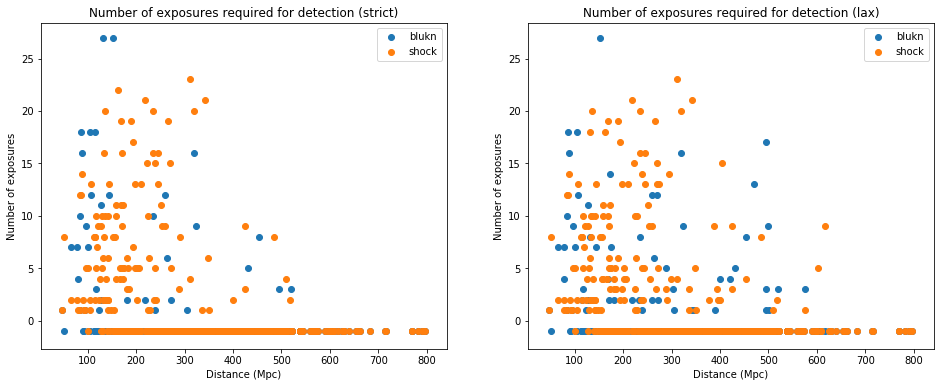

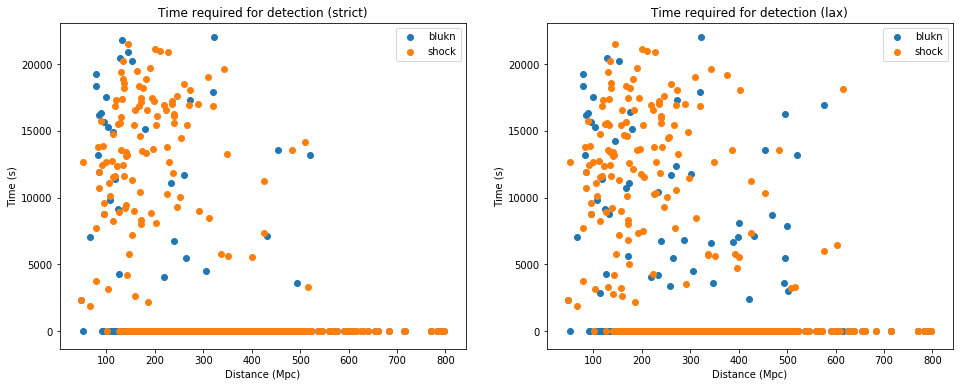

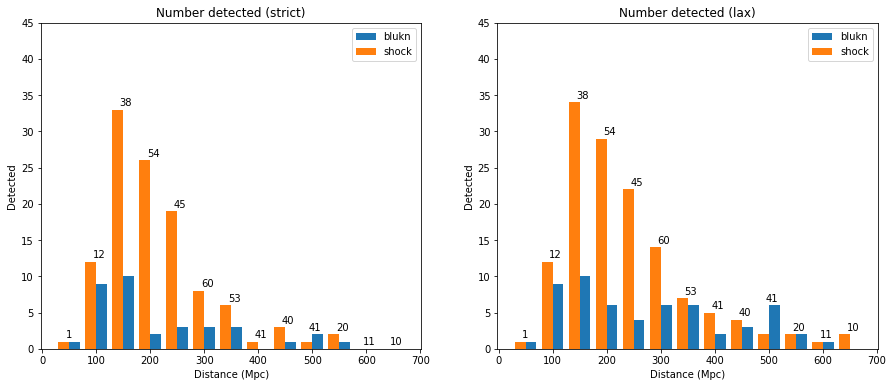

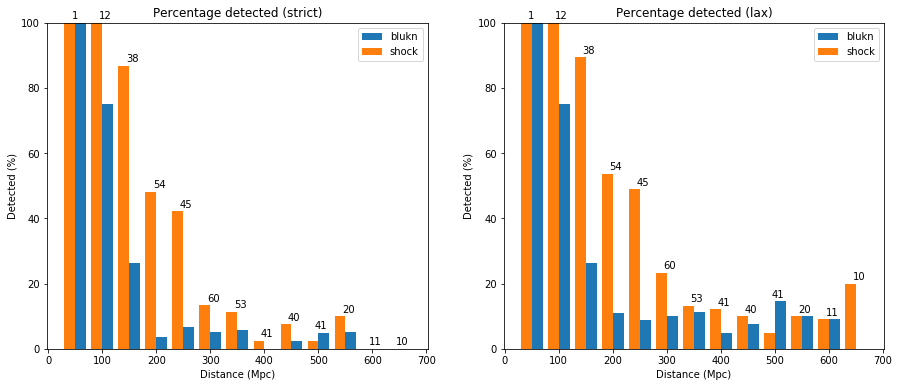

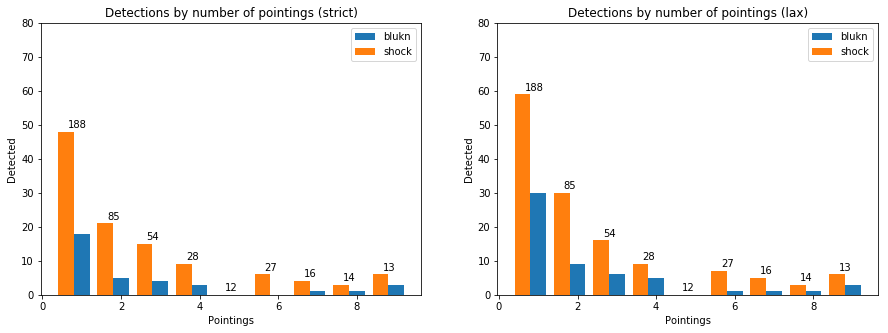

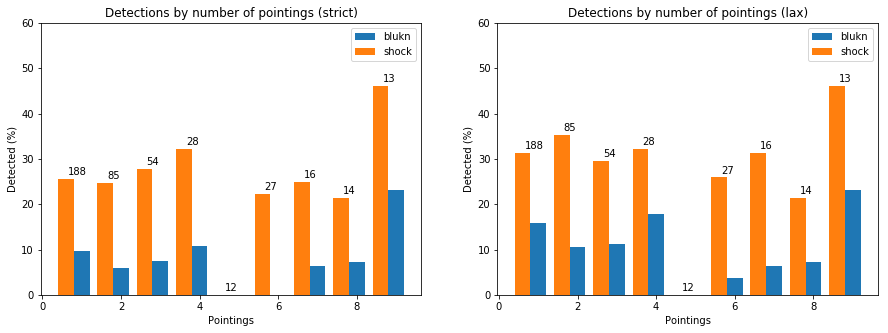

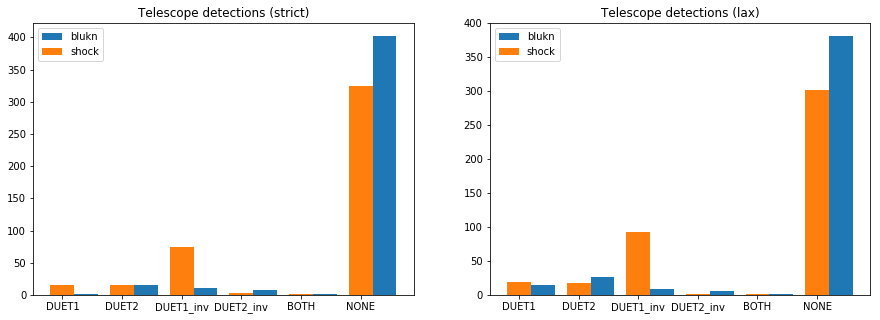

In [120]:
print('RESULTS FOR 10 MIN START')

srl = shock_res_lax_10min[(shock_res_lax_10min['pointings'] < 4) & (shock_res_lax_10min['distance'] < 300)]
brl = blukn_res_lax_10min[(blukn_res_lax_10min['pointings'] < 4) & (blukn_res_lax_10min['distance'] < 300)]

shock_time = srl['det_time'] - srl['start_time']
blukn_time = brl['det_time'] - brl['start_time']

print('Shock events detected within...')
print('2 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 7200)]), len(srl)))
print('3 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 10800)]), len(srl)))
print('4 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 14400)]), len(srl)))
print('6 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 21600)]), len(srl)))

print('Blukn events detected within...')
print('2 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 7200)]), len(brl)))
print('3 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 10800)]), len(brl)))
print('4 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 14400)]), len(brl)))
print('6 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 21600)]), len(brl)))

plot_all_the_things(shock_res_strict_10min,shock_res_lax_10min,blukn_res_strict_10min,blukn_res_lax_10min)

In [83]:
# Results for 40 mins

# Sort out results table
results_file = fits.open('../astroduet/data/emgw_40min_results.fits')
results = results_file[1].data
results_file.close()

# Strict results (no false positives)
shock_res_strict_40min = results[(results['model'] == 'shock') & (results['false'] == 0)]
blukn_res_strict_40min = results[(results['model'] == 'blukn') & (results['false'] == 0)]

# More lax - including false positives (first instance thereof)
shock_res_lax_40min = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'band', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'S9', 'i1'))
blukn_res_lax_40min = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'band', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'S9', 'i1'))
for rid in np.unique(results['id']):
    rows_shock = results[(results['id'] == rid) & (results['model'] == 'shock')]
    is_det = rows_shock[rows_shock['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        shock_res_lax_40min.add_row(min_exp[0])
    else:
        shock_res_lax_40min.add_row(rows_shock[0])

    rows_blukn = results[(results['id'] == rid) & (results['model'] == 'blukn')]
    is_det = rows_blukn[rows_blukn['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        blukn_res_lax_40min.add_row(min_exp[0])
    else:
        blukn_res_lax_40min.add_row(rows_blukn[0])

RESULTS FOR 40 MIN START
Shock events detected within...
2 hrs: 38/160
3 hrs: 46/160
4 hrs: 83/160
6 hrs: 97/160
Blukn events detected within...
2 hrs: 11/160
3 hrs: 16/160
4 hrs: 24/160
6 hrs: 27/160
Percentage detected (strict): 30.66 % (shock), 7.09 % (blue kilonova)
Percentage detected (lax): 37.07 % (shock), 13.50 % (blue kilonova)


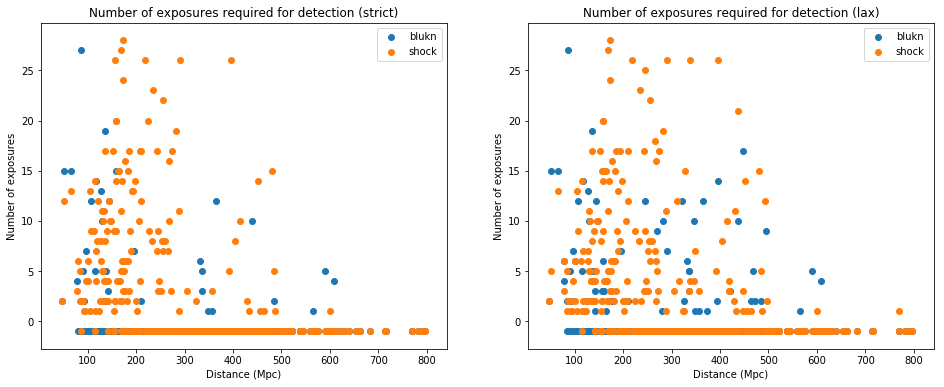

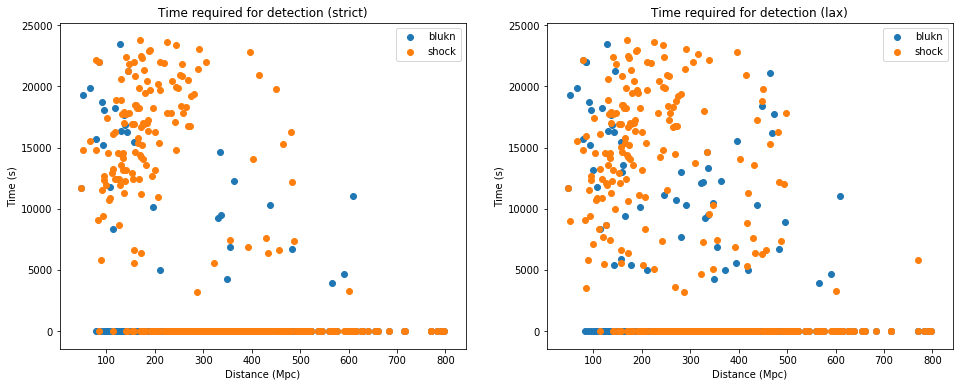

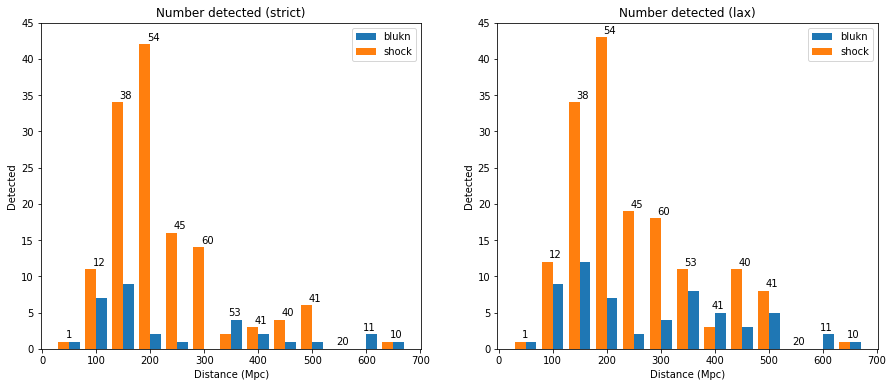

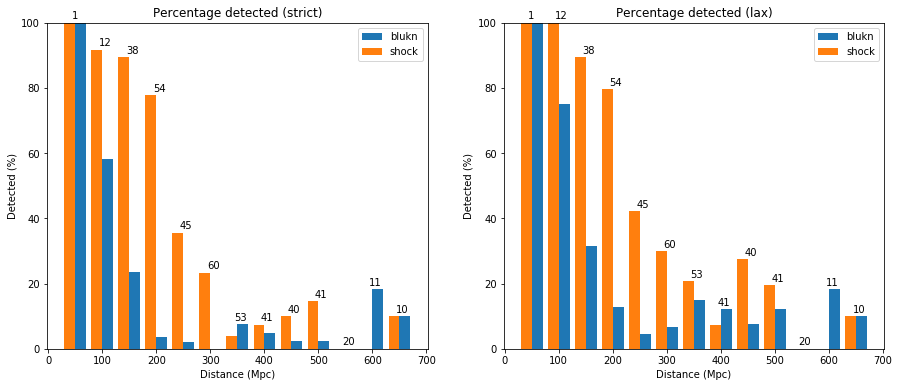

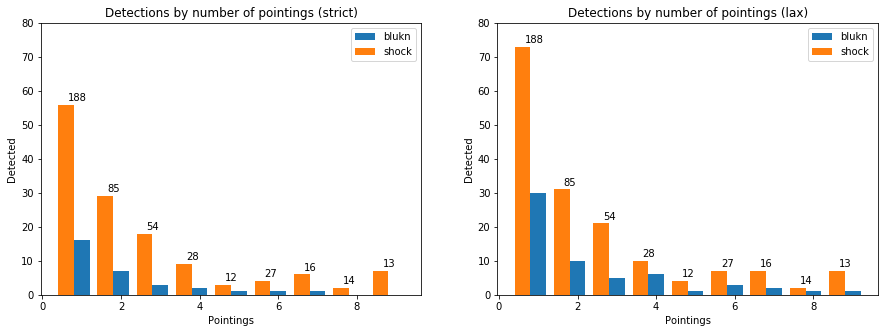

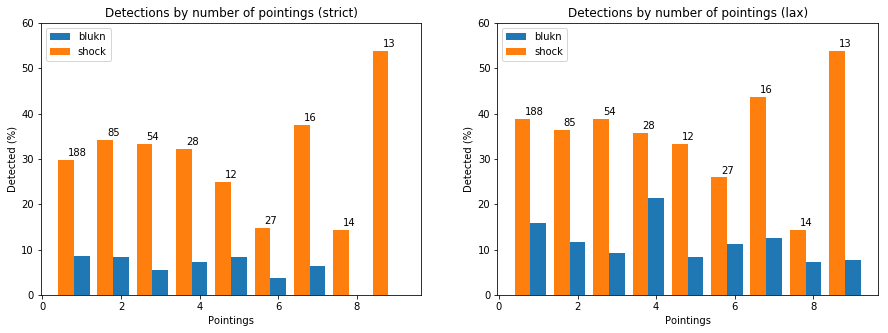

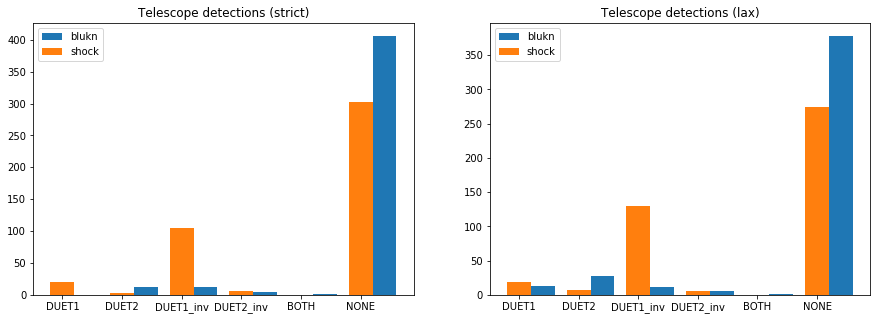

In [108]:
print('RESULTS FOR 40 MIN START')

srl = shock_res_lax_40min[(shock_res_lax_40min['pointings'] < 4) & (shock_res_lax_40min['distance'] < 300)]
brl = blukn_res_lax_40min[(blukn_res_lax_40min['pointings'] < 4) & (blukn_res_lax_40min['distance'] < 300)]

shock_time = srl['det_time'] - srl['start_time']
blukn_time = brl['det_time'] - brl['start_time']

print('Shock events detected within...')
print('2 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 7200)]), len(srl)))
print('3 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 10800)]), len(srl)))
print('4 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 14400)]), len(srl)))
print('6 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 21600)]), len(srl)))

print('Blukn events detected within...')
print('2 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 7200)]), len(brl)))
print('3 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 10800)]), len(brl)))
print('4 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 14400)]), len(brl)))
print('6 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 21600)]), len(brl)))

plot_all_the_things(shock_res_strict_40min,shock_res_lax_40min,blukn_res_strict_40min,blukn_res_lax_40min)

In [85]:
# Rerun for 70 mins (original, hence no 70 min everywhere)

# Sort out results table
results_file = fits.open('../astroduet/data/emgw_results.fits')
results = results_file[1].data
results_file.close()

# Strict results (no false positives)
shock_res_strict_70min = results[(results['model'] == 'shock') & (results['false'] == 0)]
blukn_res_strict_70min = results[(results['model'] == 'blukn') & (results['false'] == 0)]

# More lax - including false positives (first instance thereof)
shock_res_lax_70min = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'band', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'S9', 'i1'))
blukn_res_lax_70min = Table(names=('id', 'pointings', 'distance', 'start_time', 'det_time', 'model', 'num_exp', 'band', 'false'), 
                            dtype=('i2', 'i2', 'f4', 'i4', 'i4', 'S5', 'i2', 'S9', 'i1'))
for rid in np.unique(results['id']):
    rows_shock = results[(results['id'] == rid) & (results['model'] == 'shock')]
    is_det = rows_shock[rows_shock['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        shock_res_lax_70min.add_row(min_exp[0])
    else:
        shock_res_lax_70min.add_row(rows_shock[0])

    rows_blukn = results[(results['id'] == rid) & (results['model'] == 'blukn')]
    is_det = rows_blukn[rows_blukn['num_exp'] > -1]
    if len(is_det) > 0:
        min_exp = is_det[is_det['num_exp'] == np.min(is_det['num_exp'])]
        blukn_res_lax_70min.add_row(min_exp[0])
    else:
        blukn_res_lax_70min.add_row(rows_blukn[0])

RESULTS FOR 70 MIN START
Shock events detected within...
2 hrs: 49/160
3 hrs: 57/160
4 hrs: 84/160
6 hrs: 93/160
Blukn events detected within...
2 hrs: 12/160
3 hrs: 15/160
4 hrs: 18/160
6 hrs: 19/160
Percentage detected (strict): 29.52 % (shock), 5.26 % (blue kilonova)
Percentage detected (lax): 37.99 % (shock), 10.76 % (blue kilonova)


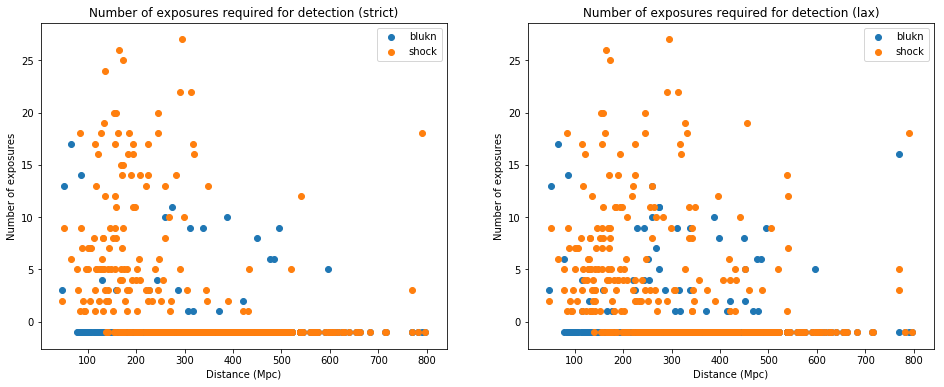

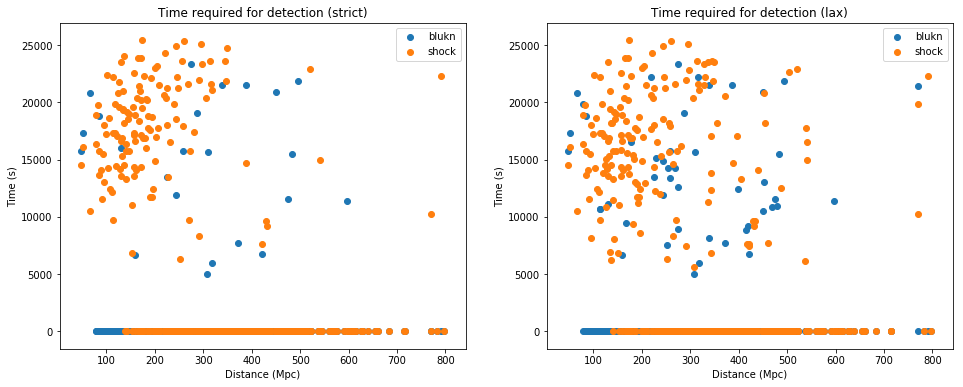

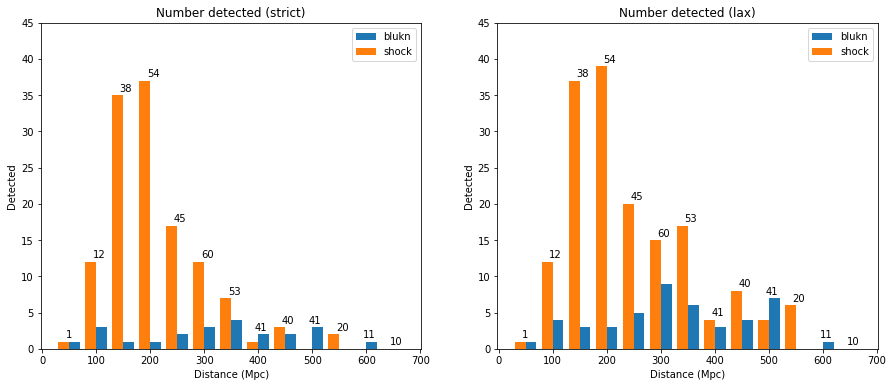

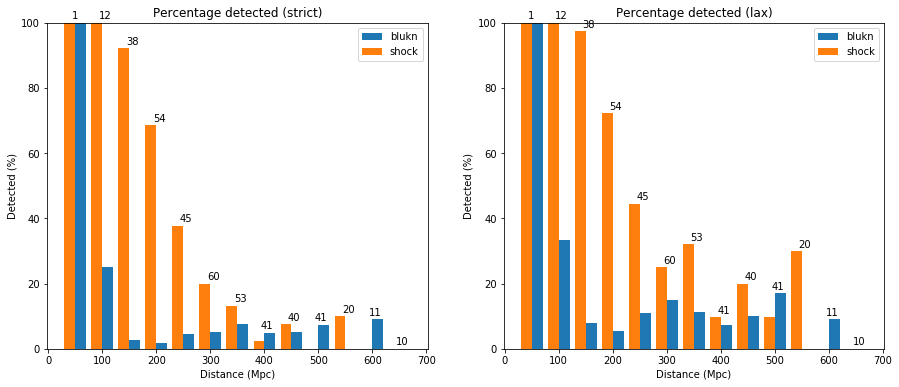

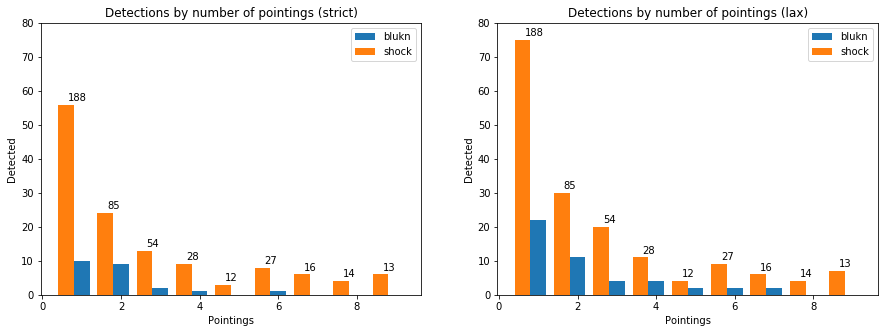

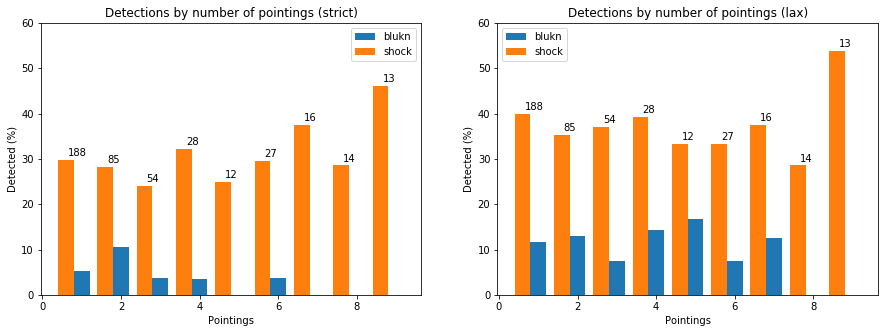

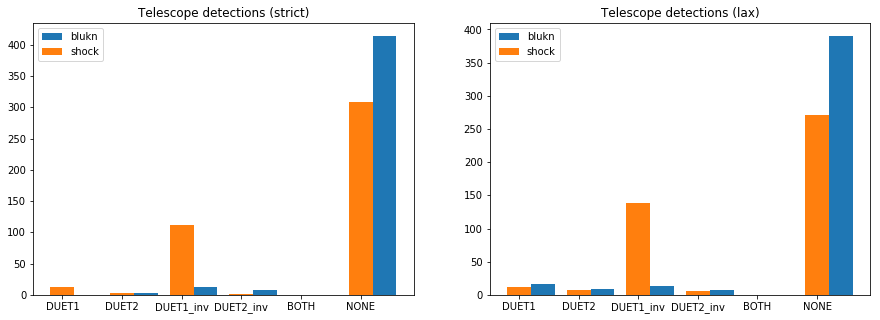

In [133]:
print('RESULTS FOR 70 MIN START')

srl = shock_res_lax_70min[(shock_res_lax_70min['pointings'] < 4) & (shock_res_lax_70min['distance'] < 300)]
brl = blukn_res_lax_70min[(blukn_res_lax_70min['pointings'] < 4) & (blukn_res_lax_70min['distance'] < 300)]

shock_time = srl['det_time'] - srl['start_time']
blukn_time = brl['det_time'] - brl['start_time']

print('Shock events detected within...')
print('2 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 7200)]), len(srl)))
print('3 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 10800)]), len(srl)))
print('4 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 14400)]), len(srl)))
print('6 hrs: {}/{}'.format(len(shock_time[(shock_time > 0) & (shock_time < 21600)]), len(srl)))

print('Blukn events detected within...')
print('2 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 7200)]), len(brl)))
print('3 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 10800)]), len(brl)))
print('4 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 14400)]), len(brl)))
print('6 hrs: {}/{}'.format(len(blukn_time[(blukn_time > 0) & (blukn_time < 21600)]), len(brl)))

plot_all_the_things(shock_res_strict_70min,shock_res_lax_70min,blukn_res_strict_70min,blukn_res_lax_70min)